In [1]:
# Needs CoolProp, Python 3.7 or greater

In [2]:
import CoolProp.CoolProp as cp
import numpy as np

In [4]:
class Brayton:
    "Implements the non-ideal regenerative, reheated-intercooled Brayton cycle."
    
    def __init__(self, T_low, T_high, P_low, p_ratio, fluid, 
                 eta_comp=0.85, eta_turb=0.90, eta_regen=0.90, del_T_HE=20,
                 reheat_intercool=False,
                 binary_mixture=False):
        """
        Initializes the Brayton cycle object.

        Parameters
        ----------
        T_low : float
            compressor inlet temperature, K
        T_high : float
            turbine inlet temperature, K
        P_low : float
            compressor inlet pressure, Pa
        p_ratio : float
            compressor/turbine pressure ratio, > 1
        fluid : str
            working fluid, valid CoolProp material
        eta_comp : float
            compressor isentropic efficiency
        eta_turb : float
            turbine isentropic efficiency
        eta_regen : float
            regenerator efficiency
        del_T_HE : float
            temperature difference across Heat Exchanger
        reheat_intercool : bool
            enable or disable reheat-intercooling
        binary_mixture : bool
            must be set to True if 'fluid' is binary mixture
            ex: 'Helium[0.5]&Xenon[0.5]'
        
        """
        self.T_low    = T_low
        self.T_high   = T_high
        self.P_low    = P_low
        self.p_ratio  = p_ratio
        self.fluid    = fluid
        self.eta_comp = eta_comp
        self.eta_turb = eta_turb
        self.eta_regen= eta_regen
        self.del_T_HE = del_T_HE
        self.reheat_intercool = reheat_intercool
        self.binary_mixture = binary_mixture
        
        if self.binary_mixture == False:
            
            self.CP    = cp.PropsSI('CP0MASS','T',self.T_low,'P',self.P_low, self.fluid) 
            self.CV    = cp.PropsSI('CVMASS', 'T',self.T_low,'P',self.P_low, self.fluid)
            self.gamma = self.CP / self.CV
        
        elif self.binary_mixture == True:
            
            raise NotImplementedError("Can't use binary mixtures yet!")

        
    def split_fluid(self, fluid):
    
        fluid_1 = fluid.split('[')[0]
        fluid_2 = fluid.split('&')[1].split('[')[0]

        return fluid_1, fluid_2
               
                
    def compute(self, verbose=True):
        """
        Computes and prints the state properties, heat rejection, and thermal efficiency.
        """
        if self.reheat_intercool==False:
            
            # set initial state
            self.T1 = self.T_low
            self.P1 = self.P_low
            self.H1 = cp.PropsSI('H','T',self.T_low,'P',self.P_low, self.fluid)
            self.S1 = cp.PropsSI('S','T',self.T_low,'P',self.P_low, self.fluid)
            
            # compute conditions at state 2 (after compressor) for ideal isentropic compression
            self.T2s = self.T1*(self.p_ratio**((self.gamma-1)/self.gamma))
            self.P2s = self.P1*self.p_ratio

            self.H2s     =  cp.PropsSI('H','T',self.T2s,'P',self.P2s, self.fluid)
            
            # ideal compressor work
            self.comp_work_s = self.H2s - self.H1

            # compute conditions at state 2 for actual compression

            # actual compressor work
            self.comp_work   = self.comp_work_s/self.eta_comp

            # actual enthalpy at state 2
            self.H2 = self.H1 + self.comp_work

            self.T2     = cp.PropsSI('T','H', self.H2, 'P',self.P2s, self.fluid)
            self.P2     = self.P2s
            self.H2     = self.H2
            self.S2     = cp.PropsSI('S','H', self.H2, 'P',self.P2s, self.fluid)
            
            # compute conditions at state 4 (combustor)
            self.T4     = self.T_high
            self.P4     = self.P2
            self.H4     = cp.PropsSI('H','T',self.T_high,'P',self.P2, self.fluid)
            self.S4     = cp.PropsSI('S','T',self.T_high,'P',self.P2, self.fluid)
            
            # compute conditions at state 5 (after turbine), assuming isentropic conditions
            self.P5s = self.P4*(1.0/self.p_ratio)

            self.H5s     =  cp.PropsSI('H','S',self.S4,'P', self.P5s, self.fluid)
            self.T5s     =  cp.PropsSI('T','S',self.S4,'P', self.P5s, self.fluid)

            # ideal turbine work
            self.turb_work_s =  self.H4 - self.H5s

            # actual turbine work
            self.turb_work   = self.turb_work_s*self.eta_turb

            # actual enthalpy at state 5
            self.H5 = self.H4 - self.turb_work

            self.T5     = cp.PropsSI('T','H',self.H5, 'P', self.P5s, self.fluid)
            self.P5     = self.P5s
            self.H5     = self.H5
            self.S5     = cp.PropsSI('S','H', self.H5, 'P',self.P5s, self.fluid)
            
            # ideal regeneration
            self.q_regen_ideal = self.H5 - self.H2

            # actual regeneration
            self.q_regen_act   = self.eta_regen*self.q_regen_ideal

            #conditions at state 6 (after heat extraction by regenerator)
            self.T6     = cp.PropsSI('T','H',self.H5 - self.q_regen_act, 'P', self.P1, self.fluid)
            self.P6     = self.P1
            self.H6     = self.H5 - self.q_regen_act
            self.S6     = cp.PropsSI('S','H',self.H5 - self.q_regen_act, 'P', self.P1, self.fluid)
            
            
            # conditions at state 3 (before combustor)
            self.T3     = cp.PropsSI('T','H',self.H2 + self.q_regen_act, 'P', self.P2, self.fluid)
            self.P3     = self.P2
            self.H3     = self.H2 + self.q_regen_act
            self.S3     = cp.PropsSI('S','H',self.H2 + self.q_regen_act, 'P', self.P2, self.fluid)
            
            # compute cycle efficiency

            self.work_net = self.turb_work - self.comp_work
            self.heat_in  = self.H4 - self.H3
            self.heat_out = self.H6 - self.H1

            self.eff = self.work_net / self.heat_in
              
        
            if verbose==True:

                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (1, self.P1/1e3, self.T1, self.H1/1e3, self.S1/1e3))
                print("State %1d, P: %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (2, self.P2/1e3, self.T2, self.H2/1e3, self.S2/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (3, self.P3/1e3, self.T3, self.H3/1e3, self.S3/1e3))
                print("State %1d, P: %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (4, self.P4/1e3, self.T4, self.H4/1e3, self.S4/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (5, self.P5/1e3, self.T5, self.H5/1e3, self.S5/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (6, self.P6/1e3, self.T6, self.H6/1e3, self.S6/1e3))
                print("-------------------------------------------------------------------")
                print("Heat Input : %1d kJ/kg" % (self.heat_in/1e3))
                print("Net Work   : %1d kJ/kg" % (self.work_net/1e3))
                print("Heat Output: %1d kJ/kg" % (self.heat_out/1e3))
                print("-------------------------------------------------------------------")
                print("Cycle Efficiency: %2.3f " % (self.eff))
                
        elif self.reheat_intercool==True:
            
            self.T1 = self.T_low
            self.P1 = self.P_low
            self.H1 = cp.PropsSI('H','T',self.T_low,'P',self.P_low, self.fluid)
            self.S1 = cp.PropsSI('S','T',self.T_low,'P',self.P_low, self.fluid)
            
            # compute conditions at state 2 (compressor 1) for ideal isentropic compression
            self.T2s = self.T1*(np.sqrt(self.p_ratio)**((self.gamma-1)/self.gamma))
            self.P2s = self.P1*np.sqrt(self.p_ratio)

            self.H2s     =  cp.PropsSI('H','T',self.T2s,'P',self.P2s, self.fluid)
            
            # ideal compressor work
            self.comp1_work_s = self.H2s - self.H1
            
            # actual compressor 1 work
            self.comp1_work   = self.comp1_work_s/self.eta_comp

            # actual enthalpy at state 2
            self.H2 = self.H1 + self.comp1_work

            self.T2     = cp.PropsSI('T','H', self.H2, 'P',self.P2s, self.fluid)
            self.P2     = self.P2s
            self.H2     = self.H2
            self.S2     = cp.PropsSI('S','H', self.H2, 'P',self.P2s, self.fluid)
            
            # state 3: intercooling to temperature T1, pressure P2.
            self.T3     = self.T1
            self.P3     = self.P2
            self.H3     = cp.PropsSI('H','T',self.T3,'P',self.P2, self.fluid)
            self.S3     = cp.PropsSI('S','T',self.T3,'P',self.P2, self.fluid)
            
            # state 4: second stage compression
            
            # compute conditions at state 4 (compressor 2) for ideal isentropic compression
            self.T4s = self.T3*(np.sqrt(self.p_ratio)**((self.gamma-1)/self.gamma))
            self.P4s = self.P3*np.sqrt(self.p_ratio)

            self.H4s     =  cp.PropsSI('H','T',self.T4s,'P',self.P4s, self.fluid)
            
            # ideal compressor 2 work
            self.comp2_work_s = self.H4s - self.H3
            
            # compute conditions at state 4 for actual compression

            # actual compressor 2 work
            self.comp2_work   = self.comp2_work_s/self.eta_comp

            # actual enthalpy at state 4
            self.H4 = self.H3 + self.comp2_work
            
            self.T4     = cp.PropsSI('T','H', self.H4, 'P',self.P4s, self.fluid)
            self.P4     = self.P4s
            self.H4     = self.H4
            self.S4     = cp.PropsSI('S','H', self.H4, 'P',self.P4s, self.fluid)
            
            # compute conditions at state 6
            self.T6     = self.T_high
            self.P6     = self.P4
            self.H6     = cp.PropsSI('H','T',self.T_high,'P',self.P4, self.fluid)
            self.S6     = cp.PropsSI('S','T',self.T_high,'P',self.P4, self.fluid)
            
            # compute conditions at state 7, assuming isentropic conditions
            self.P7s = self.P4*(1.0/np.sqrt(self.p_ratio))

            self.H7s     =  cp.PropsSI('H','S',self.S6,'P', self.P7s, self.fluid)
            self.T7s     =  cp.PropsSI('T','S',self.S6,'P', self.P7s, self.fluid)

            # ideal turbine 1 work
            self.turb1_work_s =  self.H6 - self.H7s
            
            # actual turbine 1 work
            self.turb1_work   = self.turb1_work_s*self.eta_turb
            
            # actual enthalpy at state 7
            self.H7 = self.H6 - self.turb1_work

            self.T7     = cp.PropsSI('T','H',self.H7, 'P', self.P7s, self.fluid)
            self.P7     = self.P7s
            self.H7     = self.H7
            self.S7     = cp.PropsSI('S','H', self.H7, 'P',self.P7s, self.fluid)
            
            # state 8: reheat to T_max, at pressure P7
            self.T8     = self.T_high
            self.P8     = self.P7
            self.H8     = cp.PropsSI('H','T',self.T_high,'P', self.P7, self.fluid)
            self.S8     = cp.PropsSI('S','T',self.T_high,'P', self.P7, self.fluid)
            
            self.q_reheat = self.H8 - self.H7
            
            # compute conditions at state 9, assuming isentropic conditions
            self.P9s = self.P8*(1.0/np.sqrt(self.p_ratio))
            
            self.H9s     =  cp.PropsSI('H','S',self.S8,'P', self.P9s, self.fluid)
            self.T9s     =  cp.PropsSI('T','S',self.S8,'P', self.P9s, self.fluid)

            # ideal turbine 2 work
            self.turb2_work_s =  self.H8 - self.H9s
            
            # actual turbine 1 work
            self.turb2_work   = self.turb2_work_s*self.eta_turb

            # actual enthalpy at state 9
            self.H9 = self.H8 - self.turb2_work

            #self.gas.HP = self.H9, self.P9s

            self.T9     = cp.PropsSI('T','H',self.H9, 'P', self.P9s, self.fluid)
            self.P9     = self.P9s
            self.H9     = self.H9
            self.S9     = cp.PropsSI('S','H', self.H9, 'P',self.P9s, self.fluid)
            
            # ideal regeneration
            self.q_regen_ideal = self.H9 - self.H4

            # actual regeneration
            self.q_regen_act   = self.eta_regen*self.q_regen_ideal

            #conditions at state 10
            self.T10     = cp.PropsSI('T','H',self.H9 - self.q_regen_act, 'P', self.P1, self.fluid)
            self.P10     = self.P1
            self.H10     = self.H9 - self.q_regen_act
            self.S10     = cp.PropsSI('S','H',self.H9 - self.q_regen_act, 'P', self.P1, self.fluid)
            
            # conditions at state 5
            self.T5     = cp.PropsSI('T','H',self.H2 + self.q_regen_act, 'P', self.P4, self.fluid)
            self.P5     = self.P4
            self.H5     = self.H2 + self.q_regen_act
            self.S5     = cp.PropsSI('S','H',self.H2 + self.q_regen_act, 'P', self.P4, self.fluid)
            
            # compute cycle efficiency

            self.work_net = self.turb1_work + self.turb2_work - self.comp1_work - self.comp2_work
            self.heat_in  = self.H6 - self.H5 + self.H8 - self.H7
            self.heat_out = self.H10 - self.H1

            self.eff = self.work_net / self.heat_in
        
            
            if verbose==True:

                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (1, self.P1/1e3, self.T1, self.H1/1e3, self.S1/1e3))
                print("State %1d, P: %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (2, self.P2/1e3, self.T2, self.H2/1e3, self.S2/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (3, self.P3/1e3, self.T3, self.H3/1e3, self.S3/1e3))
                print("State %1d, P: %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (4, self.P4/1e3, self.T4, self.H4/1e3, self.S4/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (5, self.P5/1e3, self.T5, self.H5/1e3, self.S5/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (6, self.P6/1e3, self.T6, self.H6/1e3, self.S6/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (7, self.P7/1e3, self.T7, self.H7/1e3, self.S7/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (8, self.P8/1e3, self.T8, self.H8/1e3, self.S8/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (9, self.P9/1e3, self.T9, self.H9/1e3, self.S9/1e3))
                print("State %1d, P:  %1.1f kPa, T: %1d K, h: %1d kJ/kg, s: %1.2f kJ/kg" % (10, self.P10/1e3, self.T10, self.H10/1e3, self.S10/1e3))
                print("-------------------------------------------------------------------")
                print("Heat Input : %1d kJ/kg" % (self.heat_in/1e3))
                print("Net Work   : %1d kJ/kg" % (self.work_net/1e3))
                print("Heat Output: %1d kJ/kg" % (self.heat_out/1e3))
                print("-------------------------------------------------------------------")
                print("Cycle Efficiency: %2.3f " % (self.eff))

In [5]:
# This example computes the results from Table 4 of Toro and Lior (2017) for N2 working fluid.
# Validation Case, ideal, no reheat-intercooling, no regeneration
Brayton1 = Brayton(T_low=200, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=1.0, eta_turb=1.0,eta_regen=0.00,
                   fluid='Nitrogen')
Brayton1.compute()

State 1, P:  101.3 kPa, T: 200 K, h: 206 kJ/kg, s: 6.42 kJ/kg
State 2, P: 1013.0 kPa, T: 385 K, h: 399 kJ/kg, s: 6.42 kJ/kg
State 3, P:  1013.0 kPa, T: 385 K, h: 399 kJ/kg, s: 6.42 kJ/kg
State 4, P: 1013.0 kPa, T: 1500 K, h: 1681 kJ/kg, s: 7.95 kJ/kg
State 5, P:  101.3 kPa, T: 844 K, h: 897 kJ/kg, s: 7.95 kJ/kg
State 6, P:  101.3 kPa, T: 844 K, h: 897 kJ/kg, s: 7.95 kJ/kg
-------------------------------------------------------------------
Heat Input : 1282 kJ/kg
Net Work   : 592 kJ/kg
Heat Output: 690 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.462 


In [6]:
# This example computes the results from Table 4 of Toro and Lior (2017) for N2 working fluid.
# Validation Case, non-ideal, no reheat-intercooling, no regeneration
Brayton2 = Brayton(T_low=200, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.9,eta_regen=0.00,
                   fluid='Nitrogen')
Brayton2.compute()

State 1, P:  101.3 kPa, T: 200 K, h: 206 kJ/kg, s: 6.42 kJ/kg
State 2, P: 1013.0 kPa, T: 405 K, h: 420 kJ/kg, s: 6.47 kJ/kg
State 3, P:  1013.0 kPa, T: 405 K, h: 420 kJ/kg, s: 6.47 kJ/kg
State 4, P: 1013.0 kPa, T: 1500 K, h: 1681 kJ/kg, s: 7.95 kJ/kg
State 5, P:  101.3 kPa, T: 913 K, h: 975 kJ/kg, s: 8.04 kJ/kg
State 6, P:  101.3 kPa, T: 913 K, h: 975 kJ/kg, s: 8.04 kJ/kg
-------------------------------------------------------------------
Heat Input : 1261 kJ/kg
Net Work   : 492 kJ/kg
Heat Output: 768 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.391 


In [7]:
# This example computes the results from Table 4 of Toro and Lior (2017) for N2 working fluid.
# Validation Case: non-ideal, no reheat-intercooling, with regeneration
Brayton3 = Brayton(T_low=200, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.9,eta_regen=0.90,
                   fluid='Nitrogen')
Brayton3.compute()

State 1, P:  101.3 kPa, T: 200 K, h: 206 kJ/kg, s: 6.42 kJ/kg
State 2, P: 1013.0 kPa, T: 405 K, h: 420 kJ/kg, s: 6.47 kJ/kg
State 3, P:  1013.0 kPa, T: 864 K, h: 920 kJ/kg, s: 7.29 kJ/kg
State 4, P: 1013.0 kPa, T: 1500 K, h: 1681 kJ/kg, s: 7.95 kJ/kg
State 5, P:  101.3 kPa, T: 913 K, h: 975 kJ/kg, s: 8.04 kJ/kg
State 6, P:  101.3 kPa, T: 457 K, h: 476 kJ/kg, s: 7.28 kJ/kg
-------------------------------------------------------------------
Heat Input : 761 kJ/kg
Net Work   : 492 kJ/kg
Heat Output: 269 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.647 


In [8]:
# This example computes the results from Table 4 of Toro and Lior (2017) for N2 working fluid.
# Validation Case: Non-ideal Brayton, with regeneration (H2)
Brayton4 = Brayton(T_low=200, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.9,eta_regen=0.90,
                   fluid='Hydrogen')
Brayton4.compute()

State 1, P:  101.3 kPa, T: 200 K, h: 2557 kJ/kg, s: 47.79 kJ/kg
State 2, P: 1013.0 kPa, T: 425 K, h: 5777 kJ/kg, s: 49.01 kJ/kg
State 3, P:  1013.0 kPa, T: 831 K, h: 11698 kJ/kg, s: 58.77 kJ/kg
State 4, P: 1013.0 kPa, T: 1500 K, h: 21946 kJ/kg, s: 67.78 kJ/kg
State 5, P:  101.3 kPa, T: 876 K, h: 12356 kJ/kg, s: 69.05 kJ/kg
State 6, P:  101.3 kPa, T: 471 K, h: 6435 kJ/kg, s: 59.99 kJ/kg
-------------------------------------------------------------------
Heat Input : 10248 kJ/kg
Net Work   : 6370 kJ/kg
Heat Output: 3878 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.622 


In [9]:
# Example 9-8 Cengel and Boles
# Validation case: ideal, with reheat, intercooling, no regeneration
Brayton5 = Brayton(T_low=300, T_high=1300, 
                   P_low=101.3e3, p_ratio=8, 
                   eta_comp=1.0, eta_turb=1.0,eta_regen=0.00,
                   fluid='Air', reheat_intercool=True)
Brayton5.compute()

State 1, P:  101.3 kPa, T: 300 K, h: 426 kJ/kg, s: 3.89 kJ/kg
State 2, P: 286.5 kPa, T: 403 K, h: 530 kJ/kg, s: 3.89 kJ/kg
State 3, P:  286.5 kPa, T: 300 K, h: 425 kJ/kg, s: 3.59 kJ/kg
State 4, P: 810.4 kPa, T: 403 K, h: 530 kJ/kg, s: 3.59 kJ/kg
State 5, P:  810.4 kPa, T: 404 K, h: 530 kJ/kg, s: 3.59 kJ/kg
State 6, P:  810.4 kPa, T: 1300 K, h: 1522 kJ/kg, s: 4.86 kJ/kg
State 7, P:  286.5 kPa, T: 1006 K, h: 1179 kJ/kg, s: 4.86 kJ/kg
State 8, P:  286.5 kPa, T: 1300 K, h: 1522 kJ/kg, s: 5.16 kJ/kg
State 9, P:  101.3 kPa, T: 1006 K, h: 1179 kJ/kg, s: 5.16 kJ/kg
State 10, P:  101.3 kPa, T: 1006 K, h: 1179 kJ/kg, s: 5.16 kJ/kg
-------------------------------------------------------------------
Heat Input : 1334 kJ/kg
Net Work   : 477 kJ/kg
Heat Output: 753 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.357 


In [10]:
# Example 9-8 Cengel and Boles
# Validation case: ideal, with reheat, intercooling, with ideal regeneration
Brayton6 = Brayton(T_low=300, T_high=1300, 
                   P_low=101.3e3, p_ratio=8, 
                   eta_comp=1.0, eta_turb=1.0,eta_regen=1.00,
                   fluid='Air', reheat_intercool=True)
Brayton6.compute()

State 1, P:  101.3 kPa, T: 300 K, h: 426 kJ/kg, s: 3.89 kJ/kg
State 2, P: 286.5 kPa, T: 403 K, h: 530 kJ/kg, s: 3.89 kJ/kg
State 3, P:  286.5 kPa, T: 300 K, h: 425 kJ/kg, s: 3.59 kJ/kg
State 4, P: 810.4 kPa, T: 403 K, h: 530 kJ/kg, s: 3.59 kJ/kg
State 5, P:  810.4 kPa, T: 1006 K, h: 1180 kJ/kg, s: 4.56 kJ/kg
State 6, P:  810.4 kPa, T: 1300 K, h: 1522 kJ/kg, s: 4.86 kJ/kg
State 7, P:  286.5 kPa, T: 1006 K, h: 1179 kJ/kg, s: 4.86 kJ/kg
State 8, P:  286.5 kPa, T: 1300 K, h: 1522 kJ/kg, s: 5.16 kJ/kg
State 9, P:  101.3 kPa, T: 1006 K, h: 1179 kJ/kg, s: 5.16 kJ/kg
State 10, P:  101.3 kPa, T: 402 K, h: 530 kJ/kg, s: 4.18 kJ/kg
-------------------------------------------------------------------
Heat Input : 685 kJ/kg
Net Work   : 477 kJ/kg
Heat Output: 103 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.696 


In [11]:
# table 9 from Toro and Lior (2017) Table 9: non-ideal, regenerative-intercooled-reheated Brayton
Brayton7 = Brayton(T_low=200, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.88, eta_turb=0.90, eta_regen=0.90,
                   fluid='Nitrogen', reheat_intercool=True)
Brayton7.compute()

State 1, P:  101.3 kPa, T: 200 K, h: 206 kJ/kg, s: 6.42 kJ/kg
State 2, P: 320.3 kPa, T: 288 K, h: 298 kJ/kg, s: 6.46 kJ/kg
State 3, P:  320.3 kPa, T: 200 K, h: 205 kJ/kg, s: 6.07 kJ/kg
State 4, P: 1013.0 kPa, T: 287 K, h: 296 kJ/kg, s: 6.11 kJ/kg
State 5, P:  1013.0 kPa, T: 1089 K, h: 1181 kJ/kg, s: 7.56 kJ/kg
State 6, P:  1013.0 kPa, T: 1500 K, h: 1681 kJ/kg, s: 7.95 kJ/kg
State 7, P:  320.3 kPa, T: 1170 K, h: 1278 kJ/kg, s: 7.99 kJ/kg
State 8, P:  320.3 kPa, T: 1500 K, h: 1680 kJ/kg, s: 8.29 kJ/kg
State 9, P:  101.3 kPa, T: 1170 K, h: 1277 kJ/kg, s: 8.33 kJ/kg
State 10, P:  101.3 kPa, T: 379 K, h: 394 kJ/kg, s: 7.09 kJ/kg
-------------------------------------------------------------------
Heat Input : 902 kJ/kg
Net Work   : 624 kJ/kg
Heat Output: 187 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.692 


In [12]:
# table 16 from Toro and Lior (2017): Regenerative-Brayton on Earth
Brayton8 = Brayton(T_low=298, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.85, eta_turb=0.90, eta_regen=0.70,
                   fluid='Air')
Brayton8.compute()

State 1, P:  101.3 kPa, T: 298 K, h: 424 kJ/kg, s: 3.88 kJ/kg
State 2, P: 1013.0 kPa, T: 622 K, h: 756 kJ/kg, s: 3.97 kJ/kg
State 3, P:  1013.0 kPa, T: 830 K, h: 982 kJ/kg, s: 4.28 kJ/kg
State 4, P: 1013.0 kPa, T: 1500 K, h: 1763 kJ/kg, s: 4.97 kJ/kg
State 5, P:  101.3 kPa, T: 917 K, h: 1079 kJ/kg, s: 5.06 kJ/kg
State 6, P:  101.3 kPa, T: 712 K, h: 853 kJ/kg, s: 4.78 kJ/kg
-------------------------------------------------------------------
Heat Input : 780 kJ/kg
Net Work   : 351 kJ/kg
Heat Output: 429 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.450 


In [13]:
# table 16 from Toro and Lior (2017): Regenerative-reheated-intercooled Brayton on Earth
Brayton9 = Brayton(T_low=298, T_high=1500, 
                   P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.85, eta_turb=0.90, eta_regen=0.80,
                   fluid='Air', reheat_intercool=True)
Brayton9.compute()

State 1, P:  101.3 kPa, T: 298 K, h: 424 kJ/kg, s: 3.88 kJ/kg
State 2, P: 320.3 kPa, T: 434 K, h: 561 kJ/kg, s: 3.93 kJ/kg
State 3, P:  320.3 kPa, T: 298 K, h: 423 kJ/kg, s: 3.55 kJ/kg
State 4, P: 1013.0 kPa, T: 434 K, h: 561 kJ/kg, s: 3.60 kJ/kg
State 5, P:  1013.0 kPa, T: 1033 K, h: 1210 kJ/kg, s: 4.53 kJ/kg
State 6, P:  1013.0 kPa, T: 1500 K, h: 1763 kJ/kg, s: 4.97 kJ/kg
State 7, P:  320.3 kPa, T: 1173 K, h: 1372 kJ/kg, s: 5.01 kJ/kg
State 8, P:  320.3 kPa, T: 1500 K, h: 1762 kJ/kg, s: 5.30 kJ/kg
State 9, P:  101.3 kPa, T: 1172 K, h: 1372 kJ/kg, s: 5.34 kJ/kg
State 10, P:  101.3 kPa, T: 590 K, h: 723 kJ/kg, s: 4.58 kJ/kg
-------------------------------------------------------------------
Heat Input : 942 kJ/kg
Net Work   : 505 kJ/kg
Heat Output: 299 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.537 


In [14]:
class Rankine:
    "Implements the non-ideal regenerative, reheated, Rankine Cycle."
    
    def __init__(self, p_max, T_max, p_min, fluid, 
                 eta_pump=1.00, eta_turb=1.00, eta_regen=0.80, 
                 regen_method = 'default', reheat=False):
        
        self.p_max = p_max
        self.T_max = T_max
        self.p_min = p_min
        
        self.fluid  = fluid
        
        self.eta_pump    = eta_pump
        self.eta_turb    = eta_turb
        self.eta_regen   = eta_regen
        
        self.regen_method = regen_method
        self.reheat       = reheat
        """
        Initializes the Rankine cycle object.

        Parameters
        ----------
    
        p_max : float
            maximum boiler presssure, Pa
        T_min : float
            temperature in condenser, K
        fluid : CoolProp fluid material
            example: ct.Water()
        eta_pump : float
            pump isentropic efficiency
        eta_turb : float
            turbine isentropic efficiency
        regen_method : str
            only default option is available
        reheat : bool
            enable or disable reheat
            
        """
        
    def compute(self, verbose=True):

        if self.regen_method=='default' and self.reheat==False:

            # conditions at state 1
            self.T1 = cp.PropsSI('T','P',self.p_min,'Q',0, self.fluid)
            self.P1 = self.p_min
            self.H1 = cp.PropsSI('H','P',self.p_min,'Q',0, self.fluid)
            self.S1 = cp.PropsSI('S','P',self.p_min,'Q',0, self.fluid)
            self.Q1 = cp.PropsSI('Q', 'P',self.P1,'Q',0, self.fluid)
            
            # isentropic compression by pump 1
            # self.fluid.SP = self.S1, self.p_int
            
            self.H2s      = cp.PropsSI('H','S',self.S1, 'P', self.p_max, self.fluid)

            # isentropic pump work
            self.pump_work_s = self.H2s - self.H1
            
            # actual pump work
            self.pump_work   = self.pump_work_s / self.eta_pump

            self.H2 = self.H1 + self.pump_work
            #self.fluid.HP = self.H2, self.p_max

            # conditions at state 2
            self.T2 = cp.PropsSI('T','H', self.H2, 'P', self.p_max, self.fluid)
            self.P2 = self.p_max
            self.H2 = self.H2
            self.S2 = cp.PropsSI('S','H', self.H2, 'P', self.p_max, self.fluid)
            self.Q2 = cp.PropsSI('Q','P', self.P2, 'Q', 0.0, self.fluid)
            
            # set conditions at state 4
            #self.fluid.TP = self.T_max, self.p_max
            #self.H4 = self.fluid.h

            # conditions at state 4
            self.T4 = self.T_max
            self.P4 = self.p_max
            self.H4 = cp.PropsSI('H','P',self.p_max, 'T', self.T_max,  self.fluid)
            self.S4 = cp.PropsSI('S','P',self.p_max, 'T', self.T_max,  self.fluid)
            self.Q4 = 1.0
            
            # isentropic expansion through turbine 
            #self.fluid.SP = self.S4, self.p_min

            # isentropic turbine work
            self.H5s = cp.PropsSI('H','S',self.S4, 'P', self.p_min,  self.fluid)
            self.turb_work_s = self.H4 - self.H5s
            
            # actual turbine  work
            self.turb_work = self.turb_work_s*self.eta_turb

            self.H5       = self.H4 - self.turb_work
            #self.fluid.HP = self.H5,  self.p_min

            # conditions at state 5
            self.T5 = cp.PropsSI('T','H', self.H5, 'P', self.p_min, self.fluid)
            self.P5 = self.p_min
            self.H5 = self.H5
            self.S5 = cp.PropsSI('S','H', self.H5, 'P', self.p_min, self.fluid)
            self.Q5 = 1.0
            
            # ideal regeneration
            self.q_regen_ideal = self.H5 - self.H2

            # actual regeneration
            self.q_regen_act   = self.eta_regen*self.q_regen_ideal

            #conditions at state 6
            #self.fluid.HP = self.H5 - self.q_regen_act , self.p_min
            self.T6     = cp.PropsSI('T','H', self.H5 - self.q_regen_act, 'P', self.p_min, self.fluid)
            self.P6     = self.p_min
            self.H6     = self.H5 - self.q_regen_act
            self.S6     = cp.PropsSI('S','H', self.H5 - self.q_regen_act, 'P', self.p_min, self.fluid)
            self.Q6     = 1.0
            
            # conditions at state 3
            #self.fluid.HP = self.H2 + self.q_regen_act , self.P2

            self.T3     = cp.PropsSI('T','H', self.H2 + self.q_regen_act, 'P', self.P2, self.fluid)
            self.P3     = self.P2
            self.H3     = self.H2 + self.q_regen_act
            self.S3     = cp.PropsSI('S','H', self.H2 + self.q_regen_act, 'P', self.p_min, self.fluid)
            self.Q3     = 1.0
            
            # compute cycle efficiency
        
            self.work_net = self.turb_work - self.pump_work
            self.heat_in  = self.H4 - self.H3
            self.heat_out = self.H6 - self.H1

            self.eff = self.work_net / (self.heat_in)

            
            if verbose==True:
                print("State %1d, P:  %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, Q: %1.2f" %  (1, self.P1/1e3, self.T1, self.H1/1e3, self.S1/1e3, self.Q1))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (2, self.P2/1e3, self.T2, self.H2/1e3, self.S2/1e3, self.Q2))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (3, self.P3/1e3, self.T3, self.H3/1e3, self.S3/1e3, self.Q3))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (4, self.P4/1e3, self.T4, self.H4/1e3, self.S4/1e3, self.Q4))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (5, self.P5/1e3, self.T5, self.H5/1e3, self.S5/1e3, self.Q5))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (6, self.P6/1e3, self.T6, self.H6/1e3, self.S6/1e3, self.Q6))
                print("-------------------------------------------------------------------")
                print("Heat Input : %1d kJ/kg" % (self.heat_in/1e3))
                print("Net Work   : %1d kJ/kg" % (self.work_net/1e3))
                print("Heat Output: %1d kJ/kg" % (self.heat_out/1e3))
                print("-------------------------------------------------------------------")
                print("Cycle Efficiency: %2.3f " % (self.eff))
                
        elif self.regen_method=='default' and self.reheat==True:
            
            # start with saturated liquid at p_min, q = 0
            
            # conditions at state 1
            self.T1 = cp.PropsSI('T','P',self.p_min,'Q',0, self.fluid)
            self.P1 = self.p_min
            self.H1 = cp.PropsSI('H','P',self.p_min,'Q',0, self.fluid)
            self.S1 = cp.PropsSI('S','P',self.p_min,'Q',0, self.fluid)
            self.Q1 = cp.PropsSI('Q', 'P',self.P1,'Q',0, self.fluid)
            
            # isentropic compression by pump 1
            # self.fluid.SP = self.S1, self.p_int
            
            self.H2s      = cp.PropsSI('H','S',self.S1, 'P', self.p_max, self.fluid)

            # isentropic pump work
            self.pump_work_s = self.H2s - self.H1
            
            # actual pump work
            self.pump_work   = self.pump_work_s / self.eta_pump

            self.H2 = self.H1 + self.pump_work
            #self.fluid.HP = self.H2, self.p_max

            # conditions at state 2
            self.T2 = cp.PropsSI('T','H', self.H2, 'P', self.p_max, self.fluid)
            self.P2 = self.p_max
            self.H2 = self.H2
            self.S2 = cp.PropsSI('S','H', self.H2, 'P', self.p_max, self.fluid)
            self.Q2 = cp.PropsSI('Q','P', self.P2, 'Q', 0.0, self.fluid)
            
            # set conditions at state 4
            #self.fluid.TP = self.T_max, self.p_max
            #self.H4 = self.fluid.h

            # conditions at state 4
            self.T4 = self.T_max
            self.P4 = self.p_max
            self.H4 = cp.PropsSI('H','P',self.p_max, 'T', self.T_max,  self.fluid)
            self.S4 = cp.PropsSI('S','P',self.p_max, 'T', self.T_max,  self.fluid)
            self.Q4 = 1.0
            
            # isentropic expansion through turbine 1 (high-pressure turbine)
            #self.fluid.SP = self.S4, self.p_max/(np.sqrt(self.p_max/self.p_min))

            # isentropic turbine work
            self.H5s = cp.PropsSI('H','S',self.S4, 'P', self.p_max/(np.sqrt(self.p_max/self.p_min)),  self.fluid)
            self.turb1_work_s = self.H4 - self.H5s
            
             # actual turbine  work
            self.turb1_work = self.turb1_work_s*self.eta_turb

            self.H5       = self.H4 - self.turb1_work
            
            #self.fluid.HP = self.H5,  self.p_max/(np.sqrt(self.p_max/self.p_min))
            # conditions at state 5
            self.T5 = cp.PropsSI('T','H', self.H5, 'P', self.p_max/(np.sqrt(self.p_max/self.p_min)), self.fluid)
            self.P5 = self.p_max/(np.sqrt(self.p_max/self.p_min))
            self.H5 = self.H5
            self.S5 = cp.PropsSI('S','H', self.H5, 'P', self.p_max/(np.sqrt(self.p_max/self.p_min)), self.fluid)
            self.Q5 = 1.0
            
            
            # state 6: reheat to T_max at pressure P5.
            
            #self.fluid.TP  =  self.T_max, self.P5
            
            self.T6     = self.T_max
            self.P6     = self.P5
            self.H6     = cp.PropsSI('H','T',self.T_max, 'P', self.P5,  self.fluid)
            self.S6     = cp.PropsSI('S','T',self.T_max, 'P', self.P5,  self.fluid)
            self.Q6     = 1.0
            
            # isentropic expansion through turbine 2 (low-pressure turbine)
            #self.fluid.SP = self.S6, self.P6/(np.sqrt(self.p_max/self.p_min))

            # isentropic turbine 2 work
            self.H7s = cp.PropsSI('H','S',self.S6, 'P', self.P6/(np.sqrt(self.p_max/self.p_min)),  self.fluid)
            self.turb2_work_s = self.H6 - self.H7s
            
            # actual turbine 2 work
            self.turb2_work = self.turb2_work_s*self.eta_turb

            self.H7       = self.H6 - self.turb2_work
            #self.fluid.HP = self.H7,  self.P6/(np.sqrt(self.p_max/self.p_min))
            
            # conditions at state 7
            self.T7 = cp.PropsSI('T','H', self.H7, 'P', self.P6/(np.sqrt(self.p_max/self.p_min)), self.fluid)
            self.P7 = self.P6/(np.sqrt(self.p_max/self.p_min))
            self.H7 = self.H7
            self.S7 = cp.PropsSI('S','H', self.H7, 'P', self.P6/(np.sqrt(self.p_max/self.p_min)), self.fluid)
            self.Q7 = 1.0
            
             # ideal regeneration
            self.q_regen_ideal = self.H7 - self.H2

            # actual regeneration
            self.q_regen_act   = self.eta_regen*self.q_regen_ideal

            #conditions at state 8
            #self.fluid.HP = self.H7 - self.q_regen_act , self.p_min
            self.T8     = cp.PropsSI('T','H', self.H7 - self.q_regen_act, 'P', self.p_min, self.fluid)
            self.P8     = self.p_min
            self.H8     = self.H7 - self.q_regen_act
            self.S8     = cp.PropsSI('S','H', self.H7 - self.q_regen_act, 'P', self.p_min, self.fluid)
            self.Q8     = 1.0
            
            # conditions at state 3
            #self.fluid.HP = self.H2 + self.q_regen_act , self.P2

            self.T3     = cp.PropsSI('T','H', self.H2 + self.q_regen_act, 'P', self.P2, self.fluid)
            self.P3     = self.P2
            self.H3     = self.H2 + self.q_regen_act
            self.S3     = cp.PropsSI('S','H', self.H2 + self.q_regen_act, 'P', self.P2, self.fluid)
            self.Q3     = 1.0
            
            # compute cycle efficiency
        
            self.work_net = self.turb1_work + self.turb2_work - self.pump_work
            self.heat_in  = self.H4 - self.H3 + self.H6 - self.H5
            self.heat_out = self.H8 - self.H1

            self.eff = self.work_net / (self.heat_in)
            
            
            if verbose==True:
        
                print("State %1d, P:  %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, Q: %1.2f" %  (1, self.P1/1e3, self.T1, self.H1/1e3, self.S1/1e3, self.Q1))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (2, self.P2/1e3, self.T2, self.H2/1e3, self.S2/1e3, self.Q2))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (3, self.P3/1e3, self.T3, self.H3/1e3, self.S3/1e3, self.Q3))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (4, self.P4/1e3, self.T4, self.H4/1e3, self.S4/1e3, self.Q4))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (5, self.P5/1e3, self.T5, self.H5/1e3, self.S5/1e3, self.Q5))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (6, self.P6/1e3, self.T6, self.H6/1e3, self.S6/1e3, self.Q6))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (7, self.P7/1e3, self.T7, self.H7/1e3, self.S7/1e3, self.Q7))
                print("State %1d, P: %1.1f kPa, T: %1.2f K, h: %1d kJ/kg, s: %1.2f kJ/kg, , Q: %1.2f" % (8, self.P8/1e3, self.T8, self.H8/1e3, self.S8/1e3, self.Q8))
                
                print("-------------------------------------------------------------------")
                print("Heat Input : %1d kJ/kg" % (self.heat_in/1e3))
                print("Net Work   : %1d kJ/kg" % (self.work_net/1e3))
                print("Heat Output: %1d kJ/kg" % (self.heat_out/1e3))
                print("-------------------------------------------------------------------")
                print("Cycle Efficiency: %2.3f " % (self.eff))

In [15]:
# This example computes the results from Table 5 of Toro and Lior (2017) for N2 working fluid.
# Validation Case: ideal, no regeneration, no reheat.
Rankine2 = Rankine(150e5, 1500, 0.15e5, 'Nitrogen', eta_pump=1.00, eta_turb=1.00, eta_regen=0.00)
Rankine2.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 66.68 K, h: -131 kJ/kg, s: 2.46 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 66.68 K, h: -131 kJ/kg, s: 2.73 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1500.00 K, h: 1695 kJ/kg, s: 7.15 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 232.92 K, h: 241 kJ/kg, s: 7.15 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 232.92 K, h: 241 kJ/kg, s: 7.15 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1827 kJ/kg
Net Work   : 1436 kJ/kg
Heat Output: 390 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.786 


In [16]:
# This example computes the results from Table 5 of Toro and Lior (2017) for N2 working fluid.
# Validation Case: non-ideal, no regeneration, no reheat
Rankine3 = Rankine(150e5, 1500, 0.15e5, 'Nitrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
Rankine3.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.49 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.76 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1500.00 K, h: 1695 kJ/kg, s: 7.15 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 372.67 K, h: 387 kJ/kg, s: 7.64 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 372.67 K, h: 387 kJ/kg, s: 7.64 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1825 kJ/kg
Net Work   : 1289 kJ/kg
Heat Output: 535 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.706 


In [17]:
# This example computes the results from Table 5 of Toro and Lior (2017) for N2 working fluid.
# Validation Case: non-ideal scenario, with regeneration, no reheat
Rankine4 = Rankine(150e5, 1500, 0.15e5, 'Nitrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.58)
Rankine4.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.49 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 217.45 K, h: 170 kJ/kg, s: 6.78 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1500.00 K, h: 1695 kJ/kg, s: 7.15 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 372.67 K, h: 387 kJ/kg, s: 7.64 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 84.72 K, h: 87 kJ/kg, s: 6.09 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1525 kJ/kg
Net Work   : 1289 kJ/kg
Heat Output: 236 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.845 


In [18]:
# This example computes the results from Table 7 of Toro and Lior (2017) for N2 working fluid.
# Validation Case: non-ideal scenario, with regeneration and reheat
Rankine5 = Rankine(150e5, 1500, 0.15e5, 'Nitrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.76,
                reheat=True)
Rankine5.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.49 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 520.86 K, h: 540 kJ/kg, s: 5.91 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1500.00 K, h: 1695 kJ/kg, s: 7.15 kJ/kg, , Q: 1.00
State 5, P: 474.3 kPa, T: 715.60 K, h: 752 kJ/kg, s: 7.30 kJ/kg, , Q: 1.00
State 6, P: 474.3 kPa, T: 1500.00 K, h: 1680 kJ/kg, s: 8.17 kJ/kg, , Q: 1.00
State 7, P: 15.0 kPa, T: 714.67 K, h: 751 kJ/kg, s: 8.33 kJ/kg, , Q: 1.00
State 8, P: 15.0 kPa, T: 79.51 K, h: 81 kJ/kg, s: 6.03 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 2083 kJ/kg
Net Work   : 1852 kJ/kg
Heat Output: 230 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.889 


In [19]:
# This example computes the results from Table 5 of Toro and Lior (2017) for Ar working fluid.
# Validation Case: non-ideal scenario, with regeneration, no reheat
Rankine6 = Rankine(150e5, 1500, 0.75e5, 'Argon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.40)
Rankine6.compute()

State 1, P:  75.0 kPa, T: 84.55 K, h: -120 kJ/kg, s: 1.34 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 88.97 K, h: -108 kJ/kg, s: 1.35 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 177.12 K, h: 0 kJ/kg, s: 2.76 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1500.00 K, h: 787 kJ/kg, s: 3.67 kJ/kg, , Q: 1.00
State 5, P: 75.0 kPa, T: 313.16 K, h: 162 kJ/kg, s: 3.96 kJ/kg, , Q: 1.00
State 6, P: 75.0 kPa, T: 105.72 K, h: 54 kJ/kg, s: 3.39 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 787 kJ/kg
Net Work   : 613 kJ/kg
Heat Output: 174 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.778 


In [20]:
# This example computes the results from Table 7 of Toro and Lior (2017) for Ar working fluid.
# Validation Case: non-ideal scenario, with regeneration and reheat
Rankine7 = Rankine(150e5, 1500, 0.75e5, 'Argon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.62,
                reheat=True)
Rankine7.compute()

State 1, P:  75.0 kPa, T: 84.55 K, h: -120 kJ/kg, s: 1.34 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 88.97 K, h: -108 kJ/kg, s: 1.35 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 341.31 K, h: 157 kJ/kg, s: 2.85 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1500.00 K, h: 787 kJ/kg, s: 3.67 kJ/kg, , Q: 1.00
State 5, P: 1060.7 kPa, T: 618.96 K, h: 321 kJ/kg, s: 3.76 kJ/kg, , Q: 1.00
State 6, P: 1060.7 kPa, T: 1500.00 K, h: 780 kJ/kg, s: 4.23 kJ/kg, , Q: 1.00
State 7, P: 75.0 kPa, T: 617.94 K, h: 321 kJ/kg, s: 4.32 kJ/kg, , Q: 1.00
State 8, P: 75.0 kPa, T: 106.69 K, h: 54 kJ/kg, s: 3.40 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1088 kJ/kg
Net Work   : 913 kJ/kg
Heat Output: 175 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.839 


In [21]:
class Stirling:
    
    "Implements the pseudo Stirling Cycle."
    
    def __init__(self, p_low, T_low, T_high, comp_ratio, fluid, eta_regen=0.85):
        
        """
        Initializes the Stirling cycle object.

        Parameters
        ----------
        p_low : float
            low pressure, Pa
        T_high : float
            high temperature, K
        T_low : float
            low temperature, K
        comp_ratio : float
            compression ratio
        fluid : str
            CoolProp fluid material
        eta_regen : float
            regenerator efficiency
        """
        
        self.p_low      = p_low
        self.T_high     = T_high
        self.T_low      = T_low
        self.comp_ratio = comp_ratio
        self.fluid      = fluid
        self.eta_regen  = eta_regen
        
        # create a cantera object for the working fluid 
        self.CP    = cp.PropsSI('CP0MASS','T',self.T_low,'P',self.p_low, self.fluid) 
        self.CV    = cp.PropsSI('CVMASS', 'T',self.T_low,'P',self.p_low, self.fluid)
        
        self.gamma = self.CP / self.CV
        
        
    def compute(self, verbose=True):
        """
        Computes pseudo-Stirling efficiency.
        """
        
    
        self.zeta     = self.T_low / self.T_high
        self.xi       = self.comp_ratio
        self.gamma    = self.gamma
        self.eps_r    = self.eta_regen
        
        #self.num       =  (1 - self.xi**(1 - self.gamma)) - self.zeta*(self.xi**(1 - self.gamma) - 1)
        #self.den       =  (1 - self.xi**(1 - self.gamma)) + (1 - self.zeta)*(1 - self.eps_r)
        
        #self.num      = self.T_high*(1 - 1/(self.r**(self.gamma-1))) - self.r**(self.gamma-1) + 1
        #self.den      = (self.T_high - 1)*(1 - self.eps_r) + self.T_high*(1 - 1/(self.r**(self.gamma-1)))
        
        self.r = self.comp_ratio
        self.tau = self.T_high / self.T_low
        
        self.num      =  self.tau*(1 - (1/self.r**(self.gamma-1))) - self.r**(self.gamma-1) + 1
        self.den      =  (self.tau - 1)*(1 - self.eps_r) + self.tau*(1 - (1/self.r**(self.gamma-1)))
        
        self.eff  = self.num / self.den
        
        if verbose==True:
            print("-------------------------------------------------------------------")
            print("Pseudo-Stirling Efficiency: %2.3f " % (self.eff))
            print("-------------------------------------------------------------------")

In [22]:
import matplotlib.pyplot as plt

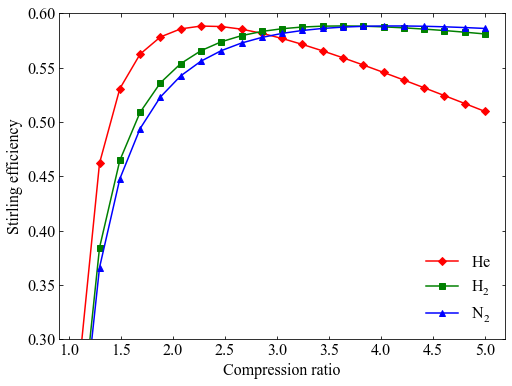

In [23]:
# This example recreates Fig. 17 from Toro and Lior (2017) for N2 and H2 working fluid.
# Validation Case.

r_arr = np.linspace(1.1, 5, 21)

n_arr1 = np.array([])
n_arr2 = np.array([])
n_arr3 = np.array([])

Stirling1 = Stirling(1e5, 200.0, 1500, r_arr[0], fluid='Helium')
Stirling2 = Stirling(1e5, 200.0, 1500, r_arr[0], fluid='Hydrogen')
Stirling3 = Stirling(1e5, 200.0, 1500, r_arr[0], fluid='Nitrogen')

for r in r_arr:
    Stirling1.comp_ratio = r
    Stirling1.compute(verbose=False)
    
    Stirling2.comp_ratio = r
    Stirling2.compute(verbose=False)
    
    Stirling3.comp_ratio = r
    Stirling3.compute(verbose=False)
    
    n_arr1 = np.append(n_arr1, Stirling1.eff)
    n_arr2 = np.append(n_arr2, Stirling2.eff)
    n_arr3 = np.append(n_arr3, Stirling3.eff)

fig = plt.figure(figsize=(8,6))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.plot(r_arr, n_arr1, 'rD-', label = r'$He$')
plt.plot(r_arr, n_arr2, 'gs-', label = r'$H_2$')
plt.plot(r_arr, n_arr3, 'b^-', label = r'$N_2$')
plt.ylim([0.3,0.60])

plt.xlabel('Compression ratio',fontsize=16)
plt.ylabel('Stirling efficiency', fontsize=16)

ax=plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)

plt.legend(loc='lower right', frameon=False, fontsize=16)

plt.savefig('toro-lior-fig-17.png', dpi=300,bbox_inches='tight')
plt.savefig('toro-lior-fig-17.pdf', dpi=300,bbox_inches='tight')
plt.savefig('toro-lior-fig-17.eps', dpi=300,bbox_inches='tight')

In [24]:
# Validation: results from Table 17, (Toro and Lior, 2017)
Striling1 = Stirling(1e5, 200.0, 1500, 2.15, fluid='Hydrogen')
Stirling1.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.510 
-------------------------------------------------------------------


In [25]:
# # Validation: results from Table 17, (Toro and Lior, 2017)
Striling2 = Stirling(1e5, 200.0, 1500, 2.3, fluid='Nitrogen')
Stirling2.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.581 
-------------------------------------------------------------------


In [26]:
# Validation: results from Table 17, (Toro and Lior, 2017)
Striling3 = Stirling(1e5, 200.0, 1500, 1.55, fluid='Helium')
Stirling3.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.586 
-------------------------------------------------------------------


In [27]:
# Validation: results for RE-1000, NASA/Sunpower (Ref: Zara and Saleh)
Stirling4 = Stirling(1e5, 303.0, 873.0, 1.5, fluid='Helium',eta_regen=0.90)
Stirling4.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.427 
-------------------------------------------------------------------


In [28]:
# Validation: results for SPDE (NASA) (Ref: Zara and Saleh)
Stirling5 = Stirling(1e5, 325.0, 650.0, 1.5, fluid='Helium',eta_regen=0.90)
Stirling5.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.285 
-------------------------------------------------------------------


In [29]:
# Validation: results for EF-1000 (Sunpower) (Ref: Zara and Saleh)
Stirling6 = Stirling(1e5, 323.0, 773.0, 1.5, fluid='Helium',eta_regen=0.80)
Stirling6.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.303 
-------------------------------------------------------------------


In [30]:
# Validation: results for EE-35 (Sunpower) (Ref: Zara and Saleh)
Stirling6 = Stirling(1e5, 353.0, 650.0, 1.5, fluid='Helium', eta_regen=0.95)
Stirling6.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.263 
-------------------------------------------------------------------


In [31]:
# Validation: results for Dai, 2021: Table 3b
Stirling7 = Stirling(1e5, 500.0, 1000.0, 1.4, fluid='Helium', eta_regen=0.95)
Stirling7.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.333 
-------------------------------------------------------------------


In [32]:
Stirling8 = Stirling(1e5, 13.0, 1300.0, 2.0, fluid='Helium', eta_regen=0.95)
Stirling8.compute()

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.868 
-------------------------------------------------------------------


In [33]:
# Generate results for summary plot

# Brayton cycle for air Brayton, no reheat, no regeneration

T1_arr = np.linspace(100, 400, 5) # temp. arr 
B1_arr = np.array([])

for T in T1_arr:
    B1   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.00, 
                   fluid='Air')
    B1.compute(verbose=False)
    B1_arr = np.append(B1_arr, B1.eff)

In [34]:
# Brayton cycle for air Brayton, no reheat, with regeneration

T2_arr = np.linspace(100, 400, 5) # temp. arr 
B2_arr = np.array([])

for T in T2_arr:
    B2   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.60, 
                   fluid='Air')
    B2.compute(verbose=False)
    B2_arr = np.append(B2_arr, B2.eff)

In [35]:
# Brayton cycle for air Brayton, with reheat, with regeneration

T3_arr = np.linspace(100, 400, 5) # temp. arr 
B3_arr = np.array([])

for T in T3_arr:
    B3   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.80, 
                   fluid='Air', reheat_intercool=True)
    B3.compute(verbose=False)
    B3_arr = np.append(B3_arr, B3.eff)

In [36]:
# Brayton cycle for He Brayton, no reheat, no regeneration

T4_arr = np.linspace(15, 200, 5) # temp. arr 
B4_arr = np.array([])

for T in T4_arr:
    B4   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.00, 
                   fluid='Helium')
    B4.compute(verbose=False)
    B4_arr = np.append(B4_arr, B4.eff)

In [37]:
# Brayton cycle for He Brayton, no reheat, with regeneration

T5_arr = np.linspace(15, 200, 5) # temp. arr 
B5_arr = np.array([])

for T in T5_arr:
    B5   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.60, 
                   fluid='Helium')
    B5.compute(verbose=False)
    B5_arr = np.append(B5_arr, B5.eff)

In [38]:
# Brayton cycle for He Brayton, with reheat, with regeneration

T6_arr = np.linspace(15, 200, 5) # temp. arr 
B6_arr = np.array([])

for T in T6_arr:
    B6   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=8, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.80, 
                   fluid='Helium', reheat_intercool=True)
    B6.compute(verbose=False)
    B6_arr = np.append(B6_arr, B6.eff)

In [39]:
# Brayton cycle for H2 Brayton, no reheat, no regeneration

T4A_arr = np.linspace(25, 200, 5) # temp. arr 
B4A_arr = np.array([])

for T in T4A_arr:
    B4A   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.00, 
                   fluid='Hydrogen')
    B4A.compute(verbose=False)
    B4A_arr = np.append(B4A_arr, B4A.eff)

In [40]:
# Brayton cycle for H2 Brayton, no reheat, with regeneration

T5A_arr = np.linspace(25, 200, 5) # temp. arr 
B5A_arr = np.array([])

for T in T4A_arr:
    B5A   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=10, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.60, 
                   fluid='Hydrogen')
    B5A.compute(verbose=False)
    B5A_arr = np.append(B5A_arr, B5A.eff)

In [41]:
# Brayton cycle for He Brayton, with reheat, with regeneration

T6A_arr = np.linspace(25, 200, 5) # temp. arr 
B6A_arr = np.array([])

for T in T6_arr:
    B6A   = Brayton(T_low=T, T_high=1300, P_low=101.3e3, p_ratio=8, 
                   eta_comp=0.9, eta_turb=0.90, eta_regen=0.80, 
                   fluid='Hydrogen', reheat_intercool=True)
    B6A.compute(verbose=False)
    B6A_arr = np.append(B6A_arr, B6A.eff)

In [42]:
# Rankine cycle for water with no reheat, no regeneration.

R1 = Rankine(150e5, 1300, 0.10e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R1.compute(verbose=True)

State 1, P:  10.0 kPa, T: 318.96 K, h: 191 kJ/kg, s: 0.65 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 319.86 K, h: 208 kJ/kg, s: 0.65 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 319.86 K, h: 208 kJ/kg, s: 0.70 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 10.0 kPa, T: 359.30 K, h: 2661 kJ/kg, s: 8.38 kJ/kg, , Q: 1.00
State 6, P: 10.0 kPa, T: 359.30 K, h: 2661 kJ/kg, s: 8.38 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 4459 kJ/kg
Net Work   : 1990 kJ/kg
Heat Output: 2469 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.446 


In [43]:
# Rankine cycle for water with no reheat, with regeneration.

R2 = Rankine(150e5, 1300, 0.10e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R2.compute()

State 1, P:  10.0 kPa, T: 318.96 K, h: 191 kJ/kg, s: 0.65 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 319.86 K, h: 208 kJ/kg, s: 0.65 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 590.00 K, h: 1434 kJ/kg, s: 4.55 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 10.0 kPa, T: 359.30 K, h: 2661 kJ/kg, s: 8.38 kJ/kg, , Q: 1.00
State 6, P: 10.0 kPa, T: 318.96 K, h: 1434 kJ/kg, s: 4.55 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 3233 kJ/kg
Net Work   : 1990 kJ/kg
Heat Output: 1243 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.616 


In [44]:
# Rankine cycle for water with reheat, with regeneration.

R3 = Rankine(150e5, 1300, 0.10e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70, reheat=True)
R3.compute()

State 1, P:  10.0 kPa, T: 318.96 K, h: 191 kJ/kg, s: 0.65 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 319.86 K, h: 208 kJ/kg, s: 0.65 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 615.31 K, h: 2376 kJ/kg, s: 4.93 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 387.3 kPa, T: 678.37 K, h: 3285 kJ/kg, s: 7.93 kJ/kg, , Q: 1.00
State 6, P: 387.3 kPa, T: 1300.00 K, h: 4708 kJ/kg, s: 9.41 kJ/kg, , Q: 1.00
State 7, P: 10.0 kPa, T: 685.63 K, h: 3305 kJ/kg, s: 9.65 kJ/kg, , Q: 1.00
State 8, P: 10.0 kPa, T: 318.96 K, h: 1137 kJ/kg, s: 3.61 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 3715 kJ/kg
Net Work   : 2769 kJ/kg
Heat Output: 945 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.745 


In [45]:
# Rankine cycle for N2 with no reheat, no regeneration.

R4 = Rankine(150e5, 1300, 0.15e5, 'Nitrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R4.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.49 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.76 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1447 kJ/kg, s: 6.97 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 316.10 K, h: 328 kJ/kg, s: 7.46 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 316.10 K, h: 328 kJ/kg, s: 7.46 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1577 kJ/kg
Net Work   : 1100 kJ/kg
Heat Output: 476 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.698 


In [46]:
# Rankine cycle for N2 with no reheat, with regeneration.

R5 = Rankine(150e5, 1300, 0.15e5, 'Nitrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R5.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.49 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 202.53 K, h: 145 kJ/kg, s: 6.62 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1447 kJ/kg, s: 6.97 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 316.10 K, h: 328 kJ/kg, s: 7.46 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 64.15 K, h: 53 kJ/kg, s: 5.61 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1302 kJ/kg
Net Work   : 1100 kJ/kg
Heat Output: 202 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.845 


In [47]:
# Rankine cycle for N2 with reheat, with regeneration.

R6 = Rankine(150e5, 1300, 0.15e5, 'Nitrogen', 
             eta_pump=0.90, eta_turb=0.90, eta_regen=0.80, 
             reheat=True)
R6.compute()

State 1, P:  15.0 kPa, T: 64.15 K, h: -148 kJ/kg, s: 2.46 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 67.67 K, h: -129 kJ/kg, s: 2.49 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 469.92 K, h: 483 kJ/kg, s: 5.80 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1447 kJ/kg, s: 6.97 kJ/kg, , Q: 1.00
State 5, P: 474.3 kPa, T: 609.37 K, h: 637 kJ/kg, s: 7.13 kJ/kg, , Q: 1.00
State 6, P: 474.3 kPa, T: 1300.00 K, h: 1434 kJ/kg, s: 8.00 kJ/kg, , Q: 1.00
State 7, P: 15.0 kPa, T: 608.73 K, h: 636 kJ/kg, s: 8.15 kJ/kg, , Q: 1.00
State 8, P: 15.0 kPa, T: 64.15 K, h: 23 kJ/kg, s: 5.14 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1762 kJ/kg
Net Work   : 1589 kJ/kg
Heat Output: 172 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.902 


In [48]:
# Rankine cycle for H2 with no reheat, no regeneration.

R7 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R7.compute()

State 1, P:  15.0 kPa, T: 15.30 K, h: -44 kJ/kg, s: -2.41 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 21.85 K, h: 164 kJ/kg, s: -1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 21.85 K, h: 164 kJ/kg, s: 11.22 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 18909 kJ/kg, s: 54.42 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 301.27 K, h: 3976 kJ/kg, s: 61.40 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 301.27 K, h: 3976 kJ/kg, s: 61.40 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 18745 kJ/kg
Net Work   : 14725 kJ/kg
Heat Output: 4020 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.786 


In [49]:
# Rankine cycle for H2 with no reheat, with regeneration.

R8 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.68)
R8.compute()

State 1, P:  15.0 kPa, T: 15.30 K, h: -44 kJ/kg, s: -2.41 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 21.85 K, h: 164 kJ/kg, s: -1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 212.19 K, h: 2756 kJ/kg, s: 56.64 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 18909 kJ/kg, s: 54.42 kJ/kg, , Q: 1.00
State 5, P: 15.0 kPa, T: 301.27 K, h: 3976 kJ/kg, s: 61.40 kJ/kg, , Q: 1.00
State 6, P: 15.0 kPa, T: 106.92 K, h: 1384 kJ/kg, s: 47.85 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 16153 kJ/kg
Net Work   : 14725 kJ/kg
Heat Output: 1428 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.912 


In [50]:
# Rankine cycle for H2 with reheat, with regeneration.

R9 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.90, reheat=True)
R9.compute()

State 1, P:  15.0 kPa, T: 15.30 K, h: -44 kJ/kg, s: -2.41 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 21.85 K, h: 164 kJ/kg, s: -1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 517.96 K, h: 7223 kJ/kg, s: 40.73 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 18909 kJ/kg, s: 54.42 kJ/kg, , Q: 1.00
State 5, P: 474.3 kPa, T: 581.02 K, h: 8029 kJ/kg, s: 56.66 kJ/kg, , Q: 1.00
State 6, P: 474.3 kPa, T: 1300.00 K, h: 18781 kJ/kg, s: 68.65 kJ/kg, , Q: 1.00
State 7, P: 15.0 kPa, T: 579.77 K, h: 8008 kJ/kg, s: 70.88 kJ/kg, , Q: 1.00
State 8, P: 15.0 kPa, T: 66.91 K, h: 948 kJ/kg, s: 42.77 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 22437 kJ/kg
Net Work   : 21444 kJ/kg
Heat Output: 992 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.956 


In [51]:
# Rankine cycle for H2 with reheat, with regeneration.

R9a = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.96, reheat=True)
R9a.compute()

State 1, P:  15.0 kPa, T: 15.30 K, h: -44 kJ/kg, s: -2.41 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 21.85 K, h: 164 kJ/kg, s: -1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 550.17 K, h: 7694 kJ/kg, s: 41.61 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 18909 kJ/kg, s: 54.42 kJ/kg, , Q: 1.00
State 5, P: 474.3 kPa, T: 581.02 K, h: 8029 kJ/kg, s: 56.66 kJ/kg, , Q: 1.00
State 6, P: 474.3 kPa, T: 1300.00 K, h: 18781 kJ/kg, s: 68.65 kJ/kg, , Q: 1.00
State 7, P: 15.0 kPa, T: 579.77 K, h: 8008 kJ/kg, s: 70.88 kJ/kg, , Q: 1.00
State 8, P: 15.0 kPa, T: 21.57 K, h: 478 kJ/kg, s: 31.02 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 21966 kJ/kg
Net Work   : 21444 kJ/kg
Heat Output: 522 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.976 


In [52]:
# Rankine with CO2, no reheat, no regeneration.

R10 = Rankine(150e5, 1300, 10e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R10.compute()

State 1, P:  1000.0 kPa, T: 233.03 K, h: 112 kJ/kg, s: 0.66 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 238.72 K, h: 126 kJ/kg, s: 0.67 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 238.72 K, h: 126 kJ/kg, s: 0.72 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 1000.0 kPa, T: 904.76 K, h: 1148 kJ/kg, s: 3.44 kJ/kg, , Q: 1.00
State 6, P: 1000.0 kPa, T: 904.76 K, h: 1148 kJ/kg, s: 3.44 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1519 kJ/kg
Net Work   : 483 kJ/kg
Heat Output: 1036 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.318 


In [53]:
# Rankine with Co2, with no reheat, with regeneration
R11 = Rankine(150e5, 1300, 10e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R11.compute()

State 1, P:  1000.0 kPa, T: 233.03 K, h: 112 kJ/kg, s: 0.66 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 238.72 K, h: 126 kJ/kg, s: 0.67 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 575.15 K, h: 739 kJ/kg, s: 2.87 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 1000.0 kPa, T: 904.76 K, h: 1148 kJ/kg, s: 3.44 kJ/kg, , Q: 1.00
State 6, P: 1000.0 kPa, T: 339.54 K, h: 535 kJ/kg, s: 2.40 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 906 kJ/kg
Net Work   : 483 kJ/kg
Heat Output: 422 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.534 


In [54]:
# Rankine with Co2, with reheat and regeneration
R12 = Rankine(150e5, 1300, 10e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.75, reheat=True)
R12.compute()

State 1, P:  1000.0 kPa, T: 233.03 K, h: 112 kJ/kg, s: 0.66 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 238.72 K, h: 126 kJ/kg, s: 0.67 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 841.90 K, h: 1061 kJ/kg, s: 2.83 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 3873.0 kPa, T: 1084.78 K, h: 1370 kJ/kg, s: 3.41 kJ/kg, , Q: 1.00
State 6, P: 3873.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.64 kJ/kg, , Q: 1.00
State 7, P: 1000.0 kPa, T: 1086.90 K, h: 1373 kJ/kg, s: 3.67 kJ/kg, , Q: 1.00
State 8, P: 1000.0 kPa, T: 235.93 K, h: 438 kJ/kg, s: 2.06 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 860 kJ/kg
Net Work   : 535 kJ/kg
Heat Output: 325 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.622 


In [55]:
# Striling cycle for H2

T7_arr = np.linspace(25, 300, 5) # temp. arr 
S1_arr = np.array([])

for T in T7_arr:
    S1   = Stirling(1e5, T, 1300, 2.50, eta_regen=0.95, fluid='Hydrogen')
    S1.compute(verbose=True)
    S1_arr = np.append(S1_arr, S1.eff)

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.870 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.789 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.718 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.654 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.592 
-------------------------------------------------------------------


In [56]:
# Striling cycle for He

T8_arr = np.linspace(5, 300, 5) # temp. arr 
S2_arr = np.array([])

for T in T8_arr:
    S2   = Stirling(1e5, T, 1300, 2.5, eta_regen=0.95, fluid='Helium')
    S2.compute(verbose=True)
    S2_arr = np.append(S2_arr, S2.eff)

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.893 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.806 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.715 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.623 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.530 
-------------------------------------------------------------------


In [57]:
T9_arr = np.linspace(25, 300, 5) # temp. arr 
S3_arr = np.array([])

for T in T7_arr:
    S3   = Stirling(1e5, T, 1300, 2.50, eta_regen=0.85, fluid='Hydrogen')
    S3.compute(verbose=True)
    S3_arr = np.append(S3_arr, S3.eff)

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.726 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.658 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.588 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.533 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.485 
-------------------------------------------------------------------


In [58]:
# Striling cycle for He

T10_arr = np.linspace(5, 300, 5) # temp. arr 
S4_arr = np.array([])

for T in T8_arr:
    S4   = Stirling(1e5, T, 1300, 2.5, eta_regen=0.85, fluid='Helium')
    S4.compute(verbose=True)
    S4_arr = np.append(S4_arr, S4.eff)

-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.744 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.679 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.608 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.535 
-------------------------------------------------------------------
-------------------------------------------------------------------
Pseudo-Stirling Efficiency: 0.459 
-------------------------------------------------------------------


In [59]:
# Rankine cycle for water at 354K with no reheat, no regeneration.

R13 = Rankine(150e5, 1300, 0.50e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R13.compute()

State 1, P:  50.0 kPa, T: 354.47 K, h: 340 kJ/kg, s: 1.09 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 355.71 K, h: 357 kJ/kg, s: 1.10 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 355.71 K, h: 357 kJ/kg, s: 1.14 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 50.0 kPa, T: 474.18 K, h: 2879 kJ/kg, s: 8.16 kJ/kg, , Q: 1.00
State 6, P: 50.0 kPa, T: 474.18 K, h: 2879 kJ/kg, s: 8.16 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 4310 kJ/kg
Net Work   : 1771 kJ/kg
Heat Output: 2539 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.411 


In [60]:
# Rankine cycle for water at 354K with no reheat, with regeneration.

R14 = Rankine(150e5, 1300, 0.50e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R14.compute()

State 1, P:  50.0 kPa, T: 354.47 K, h: 340 kJ/kg, s: 1.09 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 355.71 K, h: 357 kJ/kg, s: 1.10 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 615.31 K, h: 1618 kJ/kg, s: 4.70 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 50.0 kPa, T: 474.18 K, h: 2879 kJ/kg, s: 8.16 kJ/kg, , Q: 1.00
State 6, P: 50.0 kPa, T: 354.47 K, h: 1618 kJ/kg, s: 4.70 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 3049 kJ/kg
Net Work   : 1771 kJ/kg
Heat Output: 1278 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.581 


In [61]:
# Rankine cycle for water at 354K with reheat, with regeneration.

R15 = Rankine(150e5, 1300, 0.50e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70, reheat=True)
R15.compute()

State 1, P:  50.0 kPa, T: 354.47 K, h: 340 kJ/kg, s: 1.09 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 355.71 K, h: 357 kJ/kg, s: 1.10 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 615.31 K, h: 2577 kJ/kg, s: 5.26 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 866.0 kPa, T: 784.34 K, h: 3504 kJ/kg, s: 7.86 kJ/kg, , Q: 1.00
State 6, P: 866.0 kPa, T: 1300.00 K, h: 4707 kJ/kg, s: 9.03 kJ/kg, , Q: 1.00
State 7, P: 50.0 kPa, T: 791.40 K, h: 3528 kJ/kg, s: 9.21 kJ/kg, , Q: 1.00
State 8, P: 50.0 kPa, T: 354.47 K, h: 1308 kJ/kg, s: 3.82 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 3293 kJ/kg
Net Work   : 2325 kJ/kg
Heat Output: 968 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.706 


In [62]:
# Rankine cycle for water at 393K with no reheat, no regeneration.

R16 = Rankine(150e5, 1300, 2.00e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R16.compute()

State 1, P:  200.0 kPa, T: 393.36 K, h: 504 kJ/kg, s: 1.53 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 395.01 K, h: 522 kJ/kg, s: 1.53 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 395.01 K, h: 522 kJ/kg, s: 1.57 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 200.0 kPa, T: 602.80 K, h: 3132 kJ/kg, s: 8.00 kJ/kg, , Q: 1.00
State 6, P: 200.0 kPa, T: 602.80 K, h: 3132 kJ/kg, s: 8.00 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 4146 kJ/kg
Net Work   : 1518 kJ/kg
Heat Output: 2627 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.366 


In [63]:
# Rankine cycle for water at 393K with no reheat, with regeneration.

R17 = Rankine(150e5, 1300, 2.00e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R17.compute()

State 1, P:  200.0 kPa, T: 393.36 K, h: 504 kJ/kg, s: 1.53 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 395.01 K, h: 522 kJ/kg, s: 1.53 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 615.31 K, h: 1827 kJ/kg, s: 4.89 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 200.0 kPa, T: 602.80 K, h: 3132 kJ/kg, s: 8.00 kJ/kg, , Q: 1.00
State 6, P: 200.0 kPa, T: 393.36 K, h: 1827 kJ/kg, s: 4.89 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 2841 kJ/kg
Net Work   : 1518 kJ/kg
Heat Output: 1322 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.535 


In [64]:
# Rankine cycle for water at 393K with reheat, with regeneration.

R18 = Rankine(150e5, 1300, 2.00e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70, reheat=True)
R18.compute()

State 1, P:  200.0 kPa, T: 393.36 K, h: 504 kJ/kg, s: 1.53 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 395.01 K, h: 522 kJ/kg, s: 1.53 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 635.30 K, h: 2783 kJ/kg, s: 5.59 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 1732.1 kPa, T: 888.78 K, h: 3727 kJ/kg, s: 7.81 kJ/kg, , Q: 1.00
State 6, P: 1732.1 kPa, T: 1300.00 K, h: 4704 kJ/kg, s: 8.71 kJ/kg, , Q: 1.00
State 7, P: 200.0 kPa, T: 895.05 K, h: 3753 kJ/kg, s: 8.83 kJ/kg, , Q: 1.00
State 8, P: 200.0 kPa, T: 393.36 K, h: 1491 kJ/kg, s: 4.04 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 2861 kJ/kg
Net Work   : 1874 kJ/kg
Heat Output: 986 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.655 


In [65]:
# Rankine cycle for water at 280K with no reheat, no regeneration.

R19 = Rankine(150e5, 1300, 0.01e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R19.compute()

State 1, P:  1.0 kPa, T: 280.12 K, h: 29 kJ/kg, s: 0.11 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 280.59 K, h: 45 kJ/kg, s: 0.11 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 280.59 K, h: 45 kJ/kg, s: 0.17 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 1.0 kPa, T: 280.12 K, h: 2405 kJ/kg, s: 8.59 kJ/kg, , Q: 1.00
State 6, P: 1.0 kPa, T: 280.12 K, h: 2405 kJ/kg, s: 8.59 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 4622 kJ/kg
Net Work   : 2246 kJ/kg
Heat Output: 2376 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.486 


In [66]:
# Rankine cycle for water at 280K with no reheat, with regeneration.

R20 = Rankine(150e5, 1300, 0.01e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R20.compute()

State 1, P:  1.0 kPa, T: 280.12 K, h: 29 kJ/kg, s: 0.11 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 280.59 K, h: 45 kJ/kg, s: 0.11 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 551.72 K, h: 1225 kJ/kg, s: 4.38 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 1.0 kPa, T: 280.12 K, h: 2405 kJ/kg, s: 8.59 kJ/kg, , Q: 1.00
State 6, P: 1.0 kPa, T: 280.12 K, h: 1225 kJ/kg, s: 4.38 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 3442 kJ/kg
Net Work   : 2246 kJ/kg
Heat Output: 1196 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.652 


In [67]:
# Rankine cycle for water at 288K with reheat, with regeneration.

R21 = Rankine(150e5, 1300, 0.01e5, 'Water', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70, reheat=True)
R21.compute()

State 1, P:  1.0 kPa, T: 280.12 K, h: 29 kJ/kg, s: 0.11 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 280.59 K, h: 45 kJ/kg, s: 0.11 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 615.31 K, h: 2148 kJ/kg, s: 4.56 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 4668 kJ/kg, s: 7.69 kJ/kg, , Q: 1.00
State 5, P: 122.5 kPa, T: 552.92 K, h: 3033 kJ/kg, s: 8.05 kJ/kg, , Q: 1.00
State 6, P: 122.5 kPa, T: 1300.00 K, h: 4709 kJ/kg, s: 9.94 kJ/kg, , Q: 1.00
State 7, P: 1.0 kPa, T: 559.78 K, h: 3050 kJ/kg, s: 10.30 kJ/kg, , Q: 1.00
State 8, P: 1.0 kPa, T: 280.12 K, h: 947 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 4195 kJ/kg
Net Work   : 3277 kJ/kg
Heat Output: 917 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.781 


In [68]:
# Rankine with Co2 at 267K, with no reheat no regeneration
R22 = Rankine(150e5, 1300, 30e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R22.compute()

State 1, P:  3000.0 kPa, T: 267.60 K, h: 186 kJ/kg, s: 0.95 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 276.22 K, h: 200 kJ/kg, s: 0.96 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 276.22 K, h: 200 kJ/kg, s: 1.00 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 3000.0 kPa, T: 1048.35 K, h: 1324 kJ/kg, s: 3.42 kJ/kg, , Q: 1.00
State 6, P: 3000.0 kPa, T: 1048.35 K, h: 1324 kJ/kg, s: 3.42 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1445 kJ/kg
Net Work   : 308 kJ/kg
Heat Output: 1137 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.213 


In [69]:
# Rankine with Co2 at 267K, with no reheat, with regeneration
R23 = Rankine(150e5, 1300, 30e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R23.compute()

State 1, P:  3000.0 kPa, T: 267.60 K, h: 186 kJ/kg, s: 0.95 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 276.22 K, h: 200 kJ/kg, s: 0.96 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 687.93 K, h: 874 kJ/kg, s: 2.89 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 3000.0 kPa, T: 1048.35 K, h: 1324 kJ/kg, s: 3.42 kJ/kg, , Q: 1.00
State 6, P: 3000.0 kPa, T: 465.71 K, h: 650 kJ/kg, s: 2.49 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 771 kJ/kg
Net Work   : 308 kJ/kg
Heat Output: 463 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.399 


In [70]:
# Rankine with Co2 at 267K, with reheat and regeneration
R24 = Rankine(150e5, 1300, 30e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.75, reheat=True)
R24.compute()

State 1, P:  3000.0 kPa, T: 267.60 K, h: 186 kJ/kg, s: 0.95 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 276.22 K, h: 200 kJ/kg, s: 0.96 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 919.18 K, h: 1157 kJ/kg, s: 2.94 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 6708.2 kPa, T: 1167.42 K, h: 1474 kJ/kg, s: 3.40 kJ/kg, , Q: 1.00
State 6, P: 6708.2 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.54 kJ/kg, , Q: 1.00
State 7, P: 3000.0 kPa, T: 1168.54 K, h: 1476 kJ/kg, s: 3.55 kJ/kg, , Q: 1.00
State 8, P: 3000.0 kPa, T: 339.20 K, h: 519 kJ/kg, s: 2.16 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 660 kJ/kg
Net Work   : 327 kJ/kg
Heat Output: 332 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.496 


In [71]:
# Rankine with Co2 at 220K, with no reheat no regeneration
R25 = Rankine(150e5, 1300, 6e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R25.compute()

State 1, P:  600.0 kPa, T: 220.03 K, h: 86 kJ/kg, s: 0.55 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 224.97 K, h: 100 kJ/kg, s: 0.56 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 224.97 K, h: 100 kJ/kg, s: 0.61 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 600.0 kPa, T: 844.66 K, h: 1077 kJ/kg, s: 3.46 kJ/kg, , Q: 1.00
State 6, P: 600.0 kPa, T: 844.66 K, h: 1077 kJ/kg, s: 3.46 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1545 kJ/kg
Net Work   : 555 kJ/kg
Heat Output: 990 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.359 


In [72]:
# Rankine with Co2 at 220K, with no reheat, with regeneration
R26 = Rankine(150e5, 1300, 6e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R26.compute()

State 1, P:  600.0 kPa, T: 220.03 K, h: 86 kJ/kg, s: 0.55 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 224.97 K, h: 100 kJ/kg, s: 0.56 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 530.90 K, h: 686 kJ/kg, s: 2.87 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 600.0 kPa, T: 844.66 K, h: 1077 kJ/kg, s: 3.46 kJ/kg, , Q: 1.00
State 6, P: 600.0 kPa, T: 286.87 K, h: 491 kJ/kg, s: 2.36 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 959 kJ/kg
Net Work   : 555 kJ/kg
Heat Output: 404 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.579 


In [73]:
# Rankine with Co2 at 220K, with reheat and regeneration
R27 = Rankine(150e5, 1300, 6e5, 'CarbonDioxide', eta_pump=0.90, eta_turb=0.90, eta_regen=0.75, reheat=True)
R27.compute()

State 1, P:  600.0 kPa, T: 220.03 K, h: 86 kJ/kg, s: 0.55 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 224.97 K, h: 100 kJ/kg, s: 0.56 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 809.06 K, h: 1021 kJ/kg, s: 2.78 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.38 kJ/kg, , Q: 1.00
State 5, P: 3000.0 kPa, T: 1048.35 K, h: 1324 kJ/kg, s: 3.42 kJ/kg, , Q: 1.00
State 6, P: 3000.0 kPa, T: 1300.00 K, h: 1646 kJ/kg, s: 3.69 kJ/kg, , Q: 1.00
State 7, P: 600.0 kPa, T: 1050.84 K, h: 1328 kJ/kg, s: 3.73 kJ/kg, , Q: 1.00
State 8, P: 600.0 kPa, T: 220.03 K, h: 407 kJ/kg, s: 2.01 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 946 kJ/kg
Net Work   : 625 kJ/kg
Heat Output: 320 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.661 


In [74]:
# Rankine with Ar at 1 bar, with no reheat no regeneration
R28 = Rankine(150e5, 1300, 1e5, 'Argon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R28.compute()

State 1, P:  100.0 kPa, T: 87.18 K, h: -117 kJ/kg, s: 1.37 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 91.83 K, h: -105 kJ/kg, s: 1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 91.83 K, h: -105 kJ/kg, s: 1.51 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 682 kJ/kg, s: 3.60 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 288.38 K, h: 149 kJ/kg, s: 3.86 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 288.38 K, h: 149 kJ/kg, s: 3.86 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 788 kJ/kg
Net Work   : 520 kJ/kg
Heat Output: 267 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.661 


In [75]:
# Rankine with Ar at 1 bar, with no reheat, regeneration
R29 = Rankine(150e5, 1300, 1e5, 'Argon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R29.compute()

State 1, P:  100.0 kPa, T: 87.18 K, h: -117 kJ/kg, s: 1.37 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 91.83 K, h: -105 kJ/kg, s: 1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 190.80 K, h: 21 kJ/kg, s: 2.98 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 682 kJ/kg, s: 3.60 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 288.38 K, h: 149 kJ/kg, s: 3.86 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 87.18 K, h: 21 kJ/kg, s: 2.98 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 660 kJ/kg
Net Work   : 520 kJ/kg
Heat Output: 139 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.789 


In [76]:
# Rankine with Ar at 1 bar, with  reheat, regeneration
R30 = Rankine(150e5, 1300, 1e5, 'Argon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70, reheat=True)
R30.compute()

State 1, P:  100.0 kPa, T: 87.18 K, h: -117 kJ/kg, s: 1.37 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 91.83 K, h: -105 kJ/kg, s: 1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 363.35 K, h: 172 kJ/kg, s: 2.89 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 682 kJ/kg, s: 3.60 kJ/kg, , Q: 1.00
State 5, P: 1224.7 kPa, T: 560.31 K, h: 291 kJ/kg, s: 3.68 kJ/kg, , Q: 1.00
State 6, P: 1224.7 kPa, T: 1300.00 K, h: 676 kJ/kg, s: 4.12 kJ/kg, , Q: 1.00
State 7, P: 100.0 kPa, T: 559.56 K, h: 291 kJ/kg, s: 4.20 kJ/kg, , Q: 1.00
State 8, P: 100.0 kPa, T: 87.18 K, h: 13 kJ/kg, s: 2.87 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 896 kJ/kg
Net Work   : 765 kJ/kg
Heat Output: 130 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.854 


In [77]:
# Rankine with He at 1 bar, with no reheat no regeneration
R31 = Rankine(150e5, 1300, 1e5, 'Helium', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R31.compute()

State 1, P:  100.0 kPa, T: 4.21 K, h: 0 kJ/kg, s: 0.01 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 12.07 K, h: 92 kJ/kg, s: 0.87 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 12.07 K, h: 92 kJ/kg, s: 13.08 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 6798 kJ/kg, s: 25.25 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 288.66 K, h: 1504 kJ/kg, s: 27.84 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 288.66 K, h: 1504 kJ/kg, s: 27.84 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 6705 kJ/kg
Net Work   : 5201 kJ/kg
Heat Output: 1504 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.776 


In [78]:
# Rankine with He at 1 bar, with no reheat, regeneration
R32 = Rankine(150e5, 1300, 1e5, 'Helium', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70)
R32.compute()

State 1, P:  100.0 kPa, T: 4.21 K, h: 0 kJ/kg, s: 0.01 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 12.07 K, h: 92 kJ/kg, s: 0.87 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 198.11 K, h: 1080 kJ/kg, s: 26.11 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 6798 kJ/kg, s: 25.25 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 288.66 K, h: 1504 kJ/kg, s: 27.84 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 98.33 K, h: 516 kJ/kg, s: 22.24 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 5717 kJ/kg
Net Work   : 5201 kJ/kg
Heat Output: 515 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.910 


In [79]:
# Rankine with He at 1 bar, with reheat, regeneration
R33 = Rankine(150e5, 1300, 1e5, 'Helium', eta_pump=0.90, eta_turb=0.90, eta_regen=0.92, reheat=True)
R33.compute()

State 1, P:  100.0 kPa, T: 4.21 K, h: 0 kJ/kg, s: 0.01 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 12.07 K, h: 92 kJ/kg, s: 0.87 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 507.03 K, h: 2686 kJ/kg, s: 20.37 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 6798 kJ/kg, s: 25.25 kJ/kg, , Q: 1.00
State 5, P: 1224.7 kPa, T: 560.67 K, h: 2920 kJ/kg, s: 26.08 kJ/kg, , Q: 1.00
State 6, P: 1224.7 kPa, T: 1300.00 K, h: 6759 kJ/kg, s: 30.45 kJ/kg, , Q: 1.00
State 7, P: 100.0 kPa, T: 559.60 K, h: 2911 kJ/kg, s: 31.27 kJ/kg, , Q: 1.00
State 8, P: 100.0 kPa, T: 60.20 K, h: 317 kJ/kg, s: 19.69 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 7951 kJ/kg
Net Work   : 7633 kJ/kg
Heat Output: 317 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.960 


In [80]:
# Rankine with Ne at 1 bar, with no reheat no regeneration
R34 = Rankine(150e5, 1300, 1e5, 'Neon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R34.compute()

State 1, P:  100.0 kPa, T: 27.06 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 30.22 K, h: 13 kJ/kg, s: 0.04 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 30.22 K, h: 13 kJ/kg, s: 0.50 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1409 kJ/kg, s: 5.13 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 288.87 K, h: 357 kJ/kg, s: 5.65 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 288.87 K, h: 357 kJ/kg, s: 5.65 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1396 kJ/kg
Net Work   : 1039 kJ/kg
Heat Output: 357 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.744 


In [81]:
# Rankine with Ne at 1 bar, with no reheat, regeneration
R35 = Rankine(150e5, 1300, 1e5, 'Neon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70)
R35.compute()

State 1, P:  100.0 kPa, T: 27.06 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 30.22 K, h: 13 kJ/kg, s: 0.04 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 189.98 K, h: 254 kJ/kg, s: 5.21 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1409 kJ/kg, s: 5.13 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 288.87 K, h: 357 kJ/kg, s: 5.65 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 55.78 K, h: 116 kJ/kg, s: 3.95 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1155 kJ/kg
Net Work   : 1039 kJ/kg
Heat Output: 116 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.899 


In [82]:
# Rankine with Ne at 1 bar, with reheat, regeneration
R36 = Rankine(150e5, 1300, 1e5, 'Neon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.90, reheat=True)
R36.compute()

State 1, P:  100.0 kPa, T: 27.06 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 30.22 K, h: 13 kJ/kg, s: 0.04 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 490.95 K, h: 573 kJ/kg, s: 4.13 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 1409 kJ/kg, s: 5.13 kJ/kg, , Q: 1.00
State 5, P: 1224.7 kPa, T: 560.89 K, h: 638 kJ/kg, s: 5.30 kJ/kg, , Q: 1.00
State 6, P: 1224.7 kPa, T: 1300.00 K, h: 1399 kJ/kg, s: 6.17 kJ/kg, , Q: 1.00
State 7, P: 100.0 kPa, T: 559.62 K, h: 636 kJ/kg, s: 6.33 kJ/kg, , Q: 1.00
State 8, P: 100.0 kPa, T: 27.06 K, h: 75 kJ/kg, s: 2.80 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 1597 kJ/kg
Net Work   : 1521 kJ/kg
Heat Output: 75 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.953 


In [83]:
# Rankine with Kr at 1 bar, with no reheat no regeneration
R37 = Rankine(150e5, 1300, 1e5, 'Krypton', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R37.compute()

State 1, P:  100.0 kPa, T: 119.57 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 125.26 K, h: 6 kJ/kg, s: 0.00 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 125.26 K, h: 6 kJ/kg, s: 0.06 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 402 kJ/kg, s: 0.99 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 287.48 K, h: 149 kJ/kg, s: 1.12 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 287.48 K, h: 149 kJ/kg, s: 1.12 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 396 kJ/kg
Net Work   : 246 kJ/kg
Heat Output: 149 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.622 


In [84]:
# Rankine with Kr at 1 bar, with no reheat, regeneration
R38 = Rankine(150e5, 1300, 1e5, 'Krypton', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R38.compute()

State 1, P:  100.0 kPa, T: 119.57 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 125.26 K, h: 6 kJ/kg, s: 0.00 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 242.74 K, h: 78 kJ/kg, s: 0.65 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 402 kJ/kg, s: 0.99 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 287.48 K, h: 149 kJ/kg, s: 1.12 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 119.57 K, h: 78 kJ/kg, s: 0.65 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 324 kJ/kg
Net Work   : 246 kJ/kg
Heat Output: 78 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.759 


In [85]:
# Rankine with Kr at 1 bar, with no reheat, regeneration
R39 = Rankine(150e5, 1300, 1e5, 'Krypton', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70, reheat=True)
R39.compute()

State 1, P:  100.0 kPa, T: 119.57 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 125.26 K, h: 6 kJ/kg, s: 0.00 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 381.08 K, h: 154 kJ/kg, s: 0.65 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 402 kJ/kg, s: 0.99 kJ/kg, , Q: 1.00
State 5, P: 1224.7 kPa, T: 559.54 K, h: 216 kJ/kg, s: 1.03 kJ/kg, , Q: 1.00
State 6, P: 1224.7 kPa, T: 1300.00 K, h: 401 kJ/kg, s: 1.25 kJ/kg, , Q: 1.00
State 7, P: 100.0 kPa, T: 559.48 K, h: 217 kJ/kg, s: 1.28 kJ/kg, , Q: 1.00
State 8, P: 100.0 kPa, T: 119.57 K, h: 69 kJ/kg, s: 0.58 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 433 kJ/kg
Net Work   : 363 kJ/kg
Heat Output: 69 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.839 


In [86]:
# Rankine with Xe at 1 bar, with no reheat no regeneration
R40 = Rankine(150e5, 1300, 1e5, 'Xenon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R40.compute()

State 1, P:  100.0 kPa, T: 164.82 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 171.93 K, h: 5 kJ/kg, s: 0.00 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 171.93 K, h: 5 kJ/kg, s: 0.03 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 275 kJ/kg, s: 0.59 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 285.13 K, h: 115 kJ/kg, s: 0.67 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 285.13 K, h: 115 kJ/kg, s: 0.67 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 270 kJ/kg
Net Work   : 154 kJ/kg
Heat Output: 115 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.573 


In [87]:
# Rankine with Xe at 1 bar, with no reheat, with regeneration
R41 = Rankine(150e5, 1300, 1e5, 'Xenon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.50)
R41.compute()

State 1, P:  100.0 kPa, T: 164.82 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 171.93 K, h: 5 kJ/kg, s: 0.00 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 316.33 K, h: 60 kJ/kg, s: 0.37 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 275 kJ/kg, s: 0.59 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 285.13 K, h: 115 kJ/kg, s: 0.67 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 164.82 K, h: 60 kJ/kg, s: 0.37 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 215 kJ/kg
Net Work   : 154 kJ/kg
Heat Output: 60 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.719 


In [88]:
# Rankine with Xe at 1 bar, with no reheat, with regeneration
R42 = Rankine(150e5, 1300, 1e5, 'Xenon', eta_pump=0.90, eta_turb=0.90, eta_regen=0.70)
R42.compute()

State 1, P:  100.0 kPa, T: 164.82 K, h: 0 kJ/kg, s: -0.00 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 171.93 K, h: 5 kJ/kg, s: 0.00 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 354.90 K, h: 82 kJ/kg, s: 0.50 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 275 kJ/kg, s: 0.59 kJ/kg, , Q: 1.00
State 5, P: 100.0 kPa, T: 285.13 K, h: 115 kJ/kg, s: 0.67 kJ/kg, , Q: 1.00
State 6, P: 100.0 kPa, T: 164.82 K, h: 38 kJ/kg, s: 0.23 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 193 kJ/kg
Net Work   : 154 kJ/kg
Heat Output: 38 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.801 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


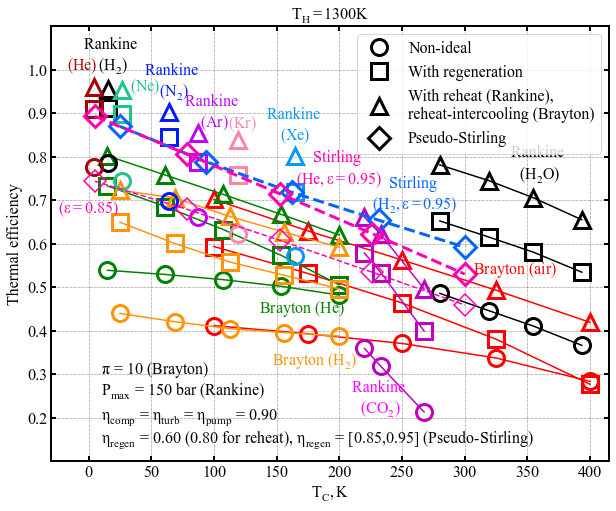

In [89]:
fig = plt.figure(figsize=(10,8))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

plt.plot(T1_arr, B1_arr, color='red', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(T2_arr, B2_arr, color='red', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(T3_arr, B3_arr, color='red', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')

plt.plot(T4_arr, B4_arr, color='green',  marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(T5_arr, B5_arr, color='green',  marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(T6_arr, B6_arr, color='green',  marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')

plt.plot(T4A_arr, B4A_arr, color='xkcd:tangerine',  marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(T5A_arr, B5A_arr, color='xkcd:tangerine',  marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(T6A_arr, B6A_arr, color='xkcd:tangerine',  marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')


plt.plot(np.array([R19.T1, R1.T1, R13.T1, R16.T1]), np.array([R19.eff, R1.eff, R13.eff, R16.eff]), color='k', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(np.array([R20.T1, R2.T1, R14.T1, R17.T1]), np.array([R20.eff, R2.eff, R14.eff, R17.eff, ]), color='k', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(np.array([R21.T1, R3.T1, R15.T1, R18.T1]), np.array([R21.eff, R3.eff, R15.eff, R18.eff]), color='k', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')


plt.plot(R4.T1, R4.eff, color='xkcd:rich blue', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='none')
plt.plot(R5.T1, R5.eff, color='xkcd:rich blue', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='none')
plt.plot(R6.T1, R6.eff, color='xkcd:rich blue', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='none')

plt.plot(R7.T1, R7.eff, color='k', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='none', label='Non-ideal')
plt.plot(R8.T1, R8.eff, color='k', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='none', label='With regeneration')
plt.plot(R9.T1, R9.eff, color='k', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='none', label='With reheat (Rankine), \n' + 'reheat-intercooling (Brayton)')

plt.plot(R28.T1, R28.eff, color='xkcd:bright purple', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R29.T1, R29.eff, color='xkcd:bright purple', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R30.T1, R30.eff, color='xkcd:bright purple', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')

plt.plot(R31.T1, R31.eff, color='xkcd:darkish red', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R32.T1, R32.eff, color='xkcd:darkish red', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R33.T1, R33.eff, color='xkcd:darkish red', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')

plt.plot(R34.T1, R34.eff, color='xkcd:greenblue', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R35.T1, R35.eff, color='xkcd:greenblue', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R36.T1, R36.eff, color='xkcd:greenblue', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')

plt.plot(R37.T1, R37.eff, color='xkcd:pinky', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R38.T1, R38.eff, color='xkcd:pinky', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R39.T1, R39.eff, color='xkcd:pinky', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')

plt.plot(R40.T1, R40.eff, color='xkcd:azure', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R41.T1, R41.eff, color='xkcd:azure', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(R42.T1, R42.eff, color='xkcd:azure', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='dashed')


plt.plot(np.array([R25.T1, R10.T1, R22.T1]), np.array([R25.eff, R10.eff, R22.eff]), color='m', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(np.array([R26.T1, R11.T1, R23.T1]), np.array([R26.eff, R11.eff, R23.eff]), color='m', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')
plt.plot(np.array([R27.T1, R12.T1, R24.T1]), np.array([R27.eff, R12.eff, R24.eff]), color='m', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid')

plt.plot(T7_arr, S1_arr, color='xkcd:bright blue', marker='D', mfc='none', linewidth=3, markeredgewidth=3, markersize=16, linestyle='dashed')
plt.plot(T8_arr, S2_arr, color='xkcd:bright pink', marker='D', mfc='none', linewidth=3, markeredgewidth=3, markersize=16, linestyle='dashed')

#plt.plot(T9_arr, S3_arr, color='xkcd:bright blue', marker='D', mfc='none', linewidth=1.5, markeredgewidth=1.5, markersize=16, linestyle='dashed')
plt.plot(T10_arr, S4_arr, color='xkcd:bright pink', marker='D', mfc='none', linewidth=1.5, markeredgewidth=1.5, markersize=16, linestyle='dashed')

plt.plot(0, 0, color='k', marker='D', mfc='none', linewidth=3, markeredgewidth=3, markersize=16, linestyle='none', label='Pseudo-Stirling')

plt.xlabel(r'$T_C, K$',fontsize=16)
plt.ylabel('Thermal efficiency', fontsize=16)

ax=plt.gca()
ax.set_yticks(np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]))
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.text(360, 0.78, 'Rankine \n'+r'$(H_2O)$', ha='center', va='center', fontsize=16)
plt.text(R4.T1+4, 0.97, 'Rankine \n'+r'$(N_2)$', ha='center', va='center', fontsize=16, color='xkcd:rich blue')
plt.text(R7.T1+4, 1.03, 'Rankine \n'+r'$(H_2)$', ha='center', va='center', fontsize=16)
plt.text(R10.T1, 0.24, 'Rankine \n'+r'$(CO_2)$', ha='center', va='center', fontsize=16, color='magenta')
plt.text(100, 0.90, 'Rankine \n'+r'$(Ar)$', ha='center', va='center', fontsize=16, color='xkcd:bright purple')
plt.text(-5, 1.01, r'$(He)$', ha='center', va='center', fontsize=16, color='xkcd:darkish red')
plt.text(45,0.96, r'$(Ne)$', ha='center', va='center', fontsize=16, color='xkcd:greenblue')
plt.text(123,0.875, r'$(Kr)$', ha='center', va='center', fontsize=16, color='xkcd:pinky')
plt.text(R40.T1, 0.87, 'Rankine \n'+r'$(Xe)$', ha='center', va='center', fontsize=16, color='xkcd:azure')
plt.text(340, 0.54 , 'Brayton '+r'$(air)$', ha='center', va='center', fontsize=16, color='red')
plt.text(170, 0.45 , 'Brayton '+r'$(He)$', ha='center', va='center', fontsize=16, color='green')
plt.text(180, 0.33 , 'Brayton '+r'$(H_2)$', ha='center', va='center', fontsize=16, color='xkcd:tangerine')
plt.text(200, 0.77 , 'Stirling \n'+r'$(He, \epsilon=0.95)$', ha='center', va='center', fontsize=16, color='xkcd:bright pink')
plt.text(260, 0.71 , 'Stirling \n'+r'$(H_2,  \epsilon=0.95)$', ha='center', va='center', fontsize=16, color='xkcd:bright blue')
plt.text(0, 0.68 , r'$(\epsilon=0.85)$', ha='center', va='center', fontsize=16, color='xkcd:bright pink')


plt.ylim([0.1, 1.10])
plt.xlim([-30, 415])

plt.title(r'$T_H = 1300 K$', fontsize=16)

plt.text(10, 0.30, r'$\pi$'+ ' = 10 (Brayton)', fontsize=16, ha='left')
plt.text(10, 0.25, r'$P_{max}$' + ' = 150 bar (Rankine)', fontsize=16, ha='left')
plt.text(10, 0.20, r'$\eta_{comp}$'+ ' = '+r'$\eta_{turb}$'+ ' = '+r'$\eta_{pump}$'+ ' = 0.90', fontsize=16, va='center', ha='left')
plt.text(10, 0.15, r'$\eta_{regen}$'+ ' = 0.60' + ' '+ r'(0.80 for reheat)' + ', '+ r'$\eta_{regen}$'+ ' = [0.85,0.95]' + ' '+ r'(Pseudo-Stirling)' , fontsize=16, va='center', ha='left')


for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
    
ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.xaxis.set_tick_params(length=5, width=2)
ax.yaxis.set_tick_params(length=5, width=2)

plt.savefig('summary-chart-8.png', dpi=300, bbox_inches='tight')
plt.savefig('summary-chart-8.pdf', dpi=300,bbox_inches='tight')
plt.savefig('summary-chart-8.eps', dpi=300,bbox_inches='tight')

In [90]:
# Rankine cycle for H2 with no reheat, no regeneration.

R43 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R44 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R45 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.90, reheat=True)

R46 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R47 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R48 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.93, reheat=True)

R49 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.00)
R50 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.60)
R51 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.90, eta_regen=0.96, reheat=True)


eta_turb_arr = np.linspace(0.80, 0.98, 11)

R43_eff = np.array([])
R44_eff = np.array([])
R45_eff = np.array([])


R46_eff = np.array([])
R47_eff = np.array([])
R48_eff = np.array([])

R49_eff = np.array([])
R50_eff = np.array([])
R51_eff = np.array([])

for eta_turb in eta_turb_arr:
    R43.eta_turb = eta_turb
    R43.compute(verbose=False)
    R43_eff = np.append(R43_eff, R43.eff)
    
    R44.eta_turb = eta_turb
    R44.compute(verbose=False)
    R44_eff = np.append(R44_eff, R44.eff)
    
    R45.eta_turb = eta_turb
    R45.compute(verbose=False)
    R45_eff = np.append(R45_eff, R45.eff)
    
    R46.eta_turb = eta_turb
    R46.compute(verbose=False)
    R46_eff = np.append(R46_eff, R46.eff)
    
    R47.eta_turb = eta_turb
    R47.compute(verbose=False)
    R47_eff = np.append(R47_eff, R47.eff)
    
    R48.eta_turb = eta_turb
    R48.compute(verbose=False)
    R48_eff = np.append(R48_eff, R48.eff)
    
    R49.eta_turb = eta_turb
    R49.compute(verbose=False)
    R49_eff = np.append(R49_eff, R49.eff)
    
    R50.eta_turb = eta_turb
    R50.compute(verbose=False)
    R50_eff = np.append(R50_eff, R50.eff)
    
    R51.eta_turb = eta_turb
    R51.compute(verbose=False)
    R51_eff = np.append(R51_eff, R51.eff)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


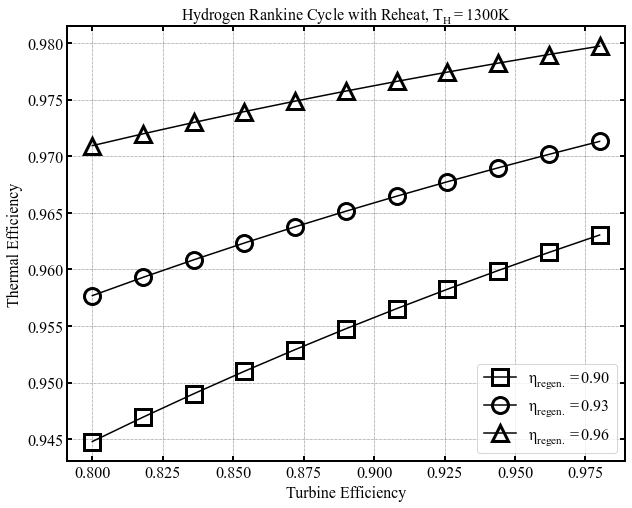

In [91]:
fig = plt.figure(figsize=(10,8))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)

#plt.plot(eta_turb_arr, R43_eff, color='k', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid', label='Non-ideal')
#plt.plot(eta_turb_arr, R44_eff, color='k', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid', label='With regeneration')

plt.plot(eta_turb_arr, R45_eff, color='k', marker='s', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid', label=r'$\eta_{regen.} = 0.90$')
plt.plot(eta_turb_arr, R48_eff, color='k', marker='o', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid', label=r'$\eta_{regen.} = 0.93$')
plt.plot(eta_turb_arr, R51_eff, color='k', marker='^', mfc='none', markeredgewidth=3, markersize=16, linestyle='solid', label=r'$\eta_{regen.} = 0.96$')


ax=plt.gca()
#ax.set_yticks(np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]))
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)

plt.xlabel(r'Turbine Efficiency',fontsize=16)
plt.ylabel('Thermal Efficiency', fontsize=16)

plt.title(r'Hydrogen Rankine Cycle with Reheat, '+r'$T_H=1300K$', fontsize=16)
         
plt.legend(loc='lower right', fontsize=16)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
    
ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.xaxis.set_tick_params(length=5, width=2)
ax.yaxis.set_tick_params(length=5, width=2)

plt.savefig('reheated-H2-rankine.png', dpi=300, bbox_inches='tight')
plt.savefig('reheated-H2-rankine.pdf', dpi=300,bbox_inches='tight')
plt.savefig('reheated-H2-rankine.eps', dpi=300,bbox_inches='tight')

In [92]:
R52 = Rankine(150e5, 1300, 0.15e5, 'Hydrogen', eta_pump=0.90, eta_turb=0.98, eta_regen=0.96, reheat=True)
R52.compute()

State 1, P:  15.0 kPa, T: 15.30 K, h: -44 kJ/kg, s: -2.41 kJ/kg, Q: 0.00
State 2, P: 15000.0 kPa, T: 21.85 K, h: 164 kJ/kg, s: -1.39 kJ/kg, , Q: 0.00
State 3, P: 15000.0 kPa, T: 487.26 K, h: 6775 kJ/kg, s: 39.84 kJ/kg, , Q: 1.00
State 4, P: 15000.0 kPa, T: 1300.00 K, h: 18909 kJ/kg, s: 54.42 kJ/kg, , Q: 1.00
State 5, P: 474.3 kPa, T: 514.46 K, h: 7062 kJ/kg, s: 54.89 kJ/kg, , Q: 1.00
State 6, P: 474.3 kPa, T: 1300.00 K, h: 18781 kJ/kg, s: 68.65 kJ/kg, , Q: 1.00
State 7, P: 15.0 kPa, T: 513.85 K, h: 7050 kJ/kg, s: 69.12 kJ/kg, , Q: 1.00
State 8, P: 15.0 kPa, T: 17.93 K, h: 439 kJ/kg, s: 29.07 kJ/kg, , Q: 1.00
-------------------------------------------------------------------
Heat Input : 23853 kJ/kg
Net Work   : 23369 kJ/kg
Heat Output: 483 kJ/kg
-------------------------------------------------------------------
Cycle Efficiency: 0.980 
